![TWD](images/twd_flag.jfif)


# Taiwanese Bankruptcy Prediction

Authors: Ramil and Erin

Image: Reuters

## Overview

We will be using data from the Taiwan Economic Journal on company financial statuses from 1999 to 2009 from [Kaggle](https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction). Our target variable is if a company went bankrupt or not in order for our stakeholder, a Taiwanese hedge fund, to make better decisions towards short positions. We have a long list of predictors such as Gross profit, operating income, taxes, and many other features listed below. 


## Business Problem

Our stakeholder is a Taiwanese hedge fund looking to profit via short selling companies operating in Taiwan. Our business problem is a classification problem to predict if a company will go bankrupt in order to advise our stakeholder on whether or not they should decide to take a short position in a company. A short position is borrowing company stock, selling it, and buying it back when it's valued less than borrow price. It is imperative that we do not mistakenly build our model to classify companies as going bankrupt as it would result in huge financial losses since the hedge fund will need to pay back the amount of stock borrowed. In order to avoid misclassifying false positives, we will tune our model with respect to precision accordingly.

## Data Understanding and Exploration

Below we will import the libraries we used in this notebook and then import and display the data.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import plot_roc_curve, auc, precision_score, accuracy_score, recall_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import xgboost

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
df = pd.read_csv('data/data.csv')

In [3]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.37,0.42,0.41,0.60,0.60,1.00,0.80,0.81,0.30,0.78,0.00,0.00,0.46,0.00,0.00,0.15,0.15,0.15,0.17,0.31,0.02,0.10,0.14,0.02,0.85,0.69,0.69,0.22,4980000000.00,0.00,0.26,0.36,0.00,0.00,0.63,0.02,0.21,0.79,0.01,0.39,0.01,0.10,0.14,0.40,0.09,0.00,0.00,0.00,0.00,0.03,0.03,0.39,0.04,0.67,0.17,0.19,0.00,0.00,0.00,0.15,0.33,0.28,0.00,0.68,0.72,0.34,0.03,0.90,0.00,0.06,701000000.00,6550000000.00,0.59,458000000.00,0.67,0.42,0.68,0.34,0.13,0.64,0.46,0.52,0.31,0.12,0,0.72,0.01,0.62,0.60,0.83,0.29,0.03,0.56,1,0.02
1,1,0.46,0.54,0.52,0.61,0.61,1.00,0.80,0.81,0.30,0.78,0.00,0.00,0.46,0.00,0.00,0.18,0.18,0.18,0.21,0.32,0.02,0.09,0.17,0.02,0.85,0.69,0.69,0.22,6110000000.00,0.00,0.26,0.38,0.01,0.00,0.64,0.01,0.17,0.83,0.01,0.38,0.01,0.09,0.17,0.40,0.06,0.00,0.00,9360000000.00,719000000.00,0.03,0.01,0.39,0.01,0.75,0.13,0.18,0.01,0.00,0.00,0.06,0.34,0.29,0.01,0.31,0.73,0.33,0.02,0.93,0.00,0.03,0.00,7700000000.00,0.59,2490000000.00,0.67,0.47,0.31,0.33,0.12,0.64,0.46,0.57,0.31,0.05,0,0.80,0.01,0.62,0.61,0.84,0.28,0.26,0.57,1,0.02
2,1,0.43,0.50,0.47,0.60,0.60,1.00,0.80,0.81,0.30,0.78,0.00,25500000.00,0.46,0.00,0.00,0.18,0.18,0.19,0.18,0.31,0.01,0.09,0.14,0.02,0.85,0.69,0.69,0.22,7280000000.00,0.00,0.26,0.37,0.01,0.01,0.63,0.02,0.21,0.79,0.01,0.38,0.01,0.09,0.15,0.41,0.01,0.00,0.00,65000000.00,2650000000.00,0.01,0.03,0.38,0.14,0.83,0.3

Below we can see that our dataset contains 6819 rows of data and 96 columns.

In [4]:
df.shape

(6819, 96)

In [5]:
print(df['Bankrupt?'].value_counts())
print(df['Bankrupt?'].value_counts(normalize=True))

0    6599
1     220
Name: Bankrupt?, dtype: int64
0   0.97
1   0.03
Name: Bankrupt?, dtype: float64


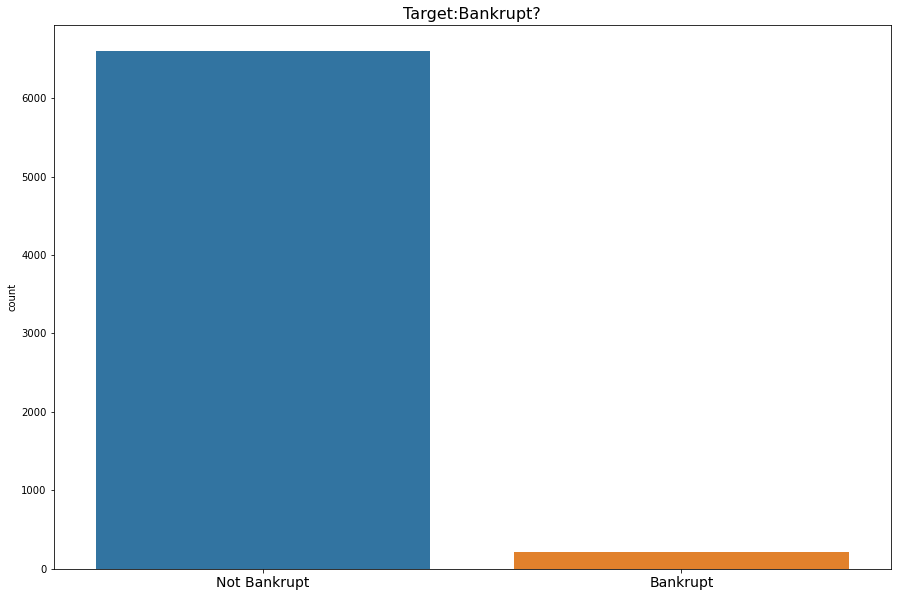

In [6]:
#plt.style.use("dark_background")
#sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(df['Bankrupt?'])
ax.set_title('Target:Bankrupt?', fontsize=16)
ax.set_xlabel('')
ax.set_xticklabels(['Not Bankrupt', 'Bankrupt'], fontsize=14)
plt.savefig('./images/target_bar.jpg', bbox_inches='tight')

- 96% vs 3% - we will need to use an oversampling technique such as SMOTE as well as undersampling.

In [7]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00
mean,0.03,0.51,0.56,0.55,0.61,0.61,1.00,0.80,0.81,0.30,0.78,1995347312.80,1950427306.06,0.47,16448012.91,0.12,0.19,0.19,0.19,0.23,0.32,1328640.60,0.11,0.18,0.02,0.85,0.69,0.69,0.22,5508096595.25,1566212.06,0.26,0.38,403284.95,8376594.82,0.63,4416336.71,0.11,0.89,0.01,0.37,0.01,0.11,0.18,0.40,0.14,12789705.24,9826220.86,2149106056.61,1008595981.82,0.04,2325854.27,0.40,11255785.32,0.81,0.40,0.52,0.12,3592902.20,37159994.15,0.09,0.35,0.28,55806804.53,0.76,0.74,0.33,54160038.14,0.93,0.00,0.03,1195855763.31,2163735272.03,0.59,2471976967.44,0.67,1220120.50,0.

We can observe we have quite a few outliers in some columns.

In [8]:
df.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

- No missing values.

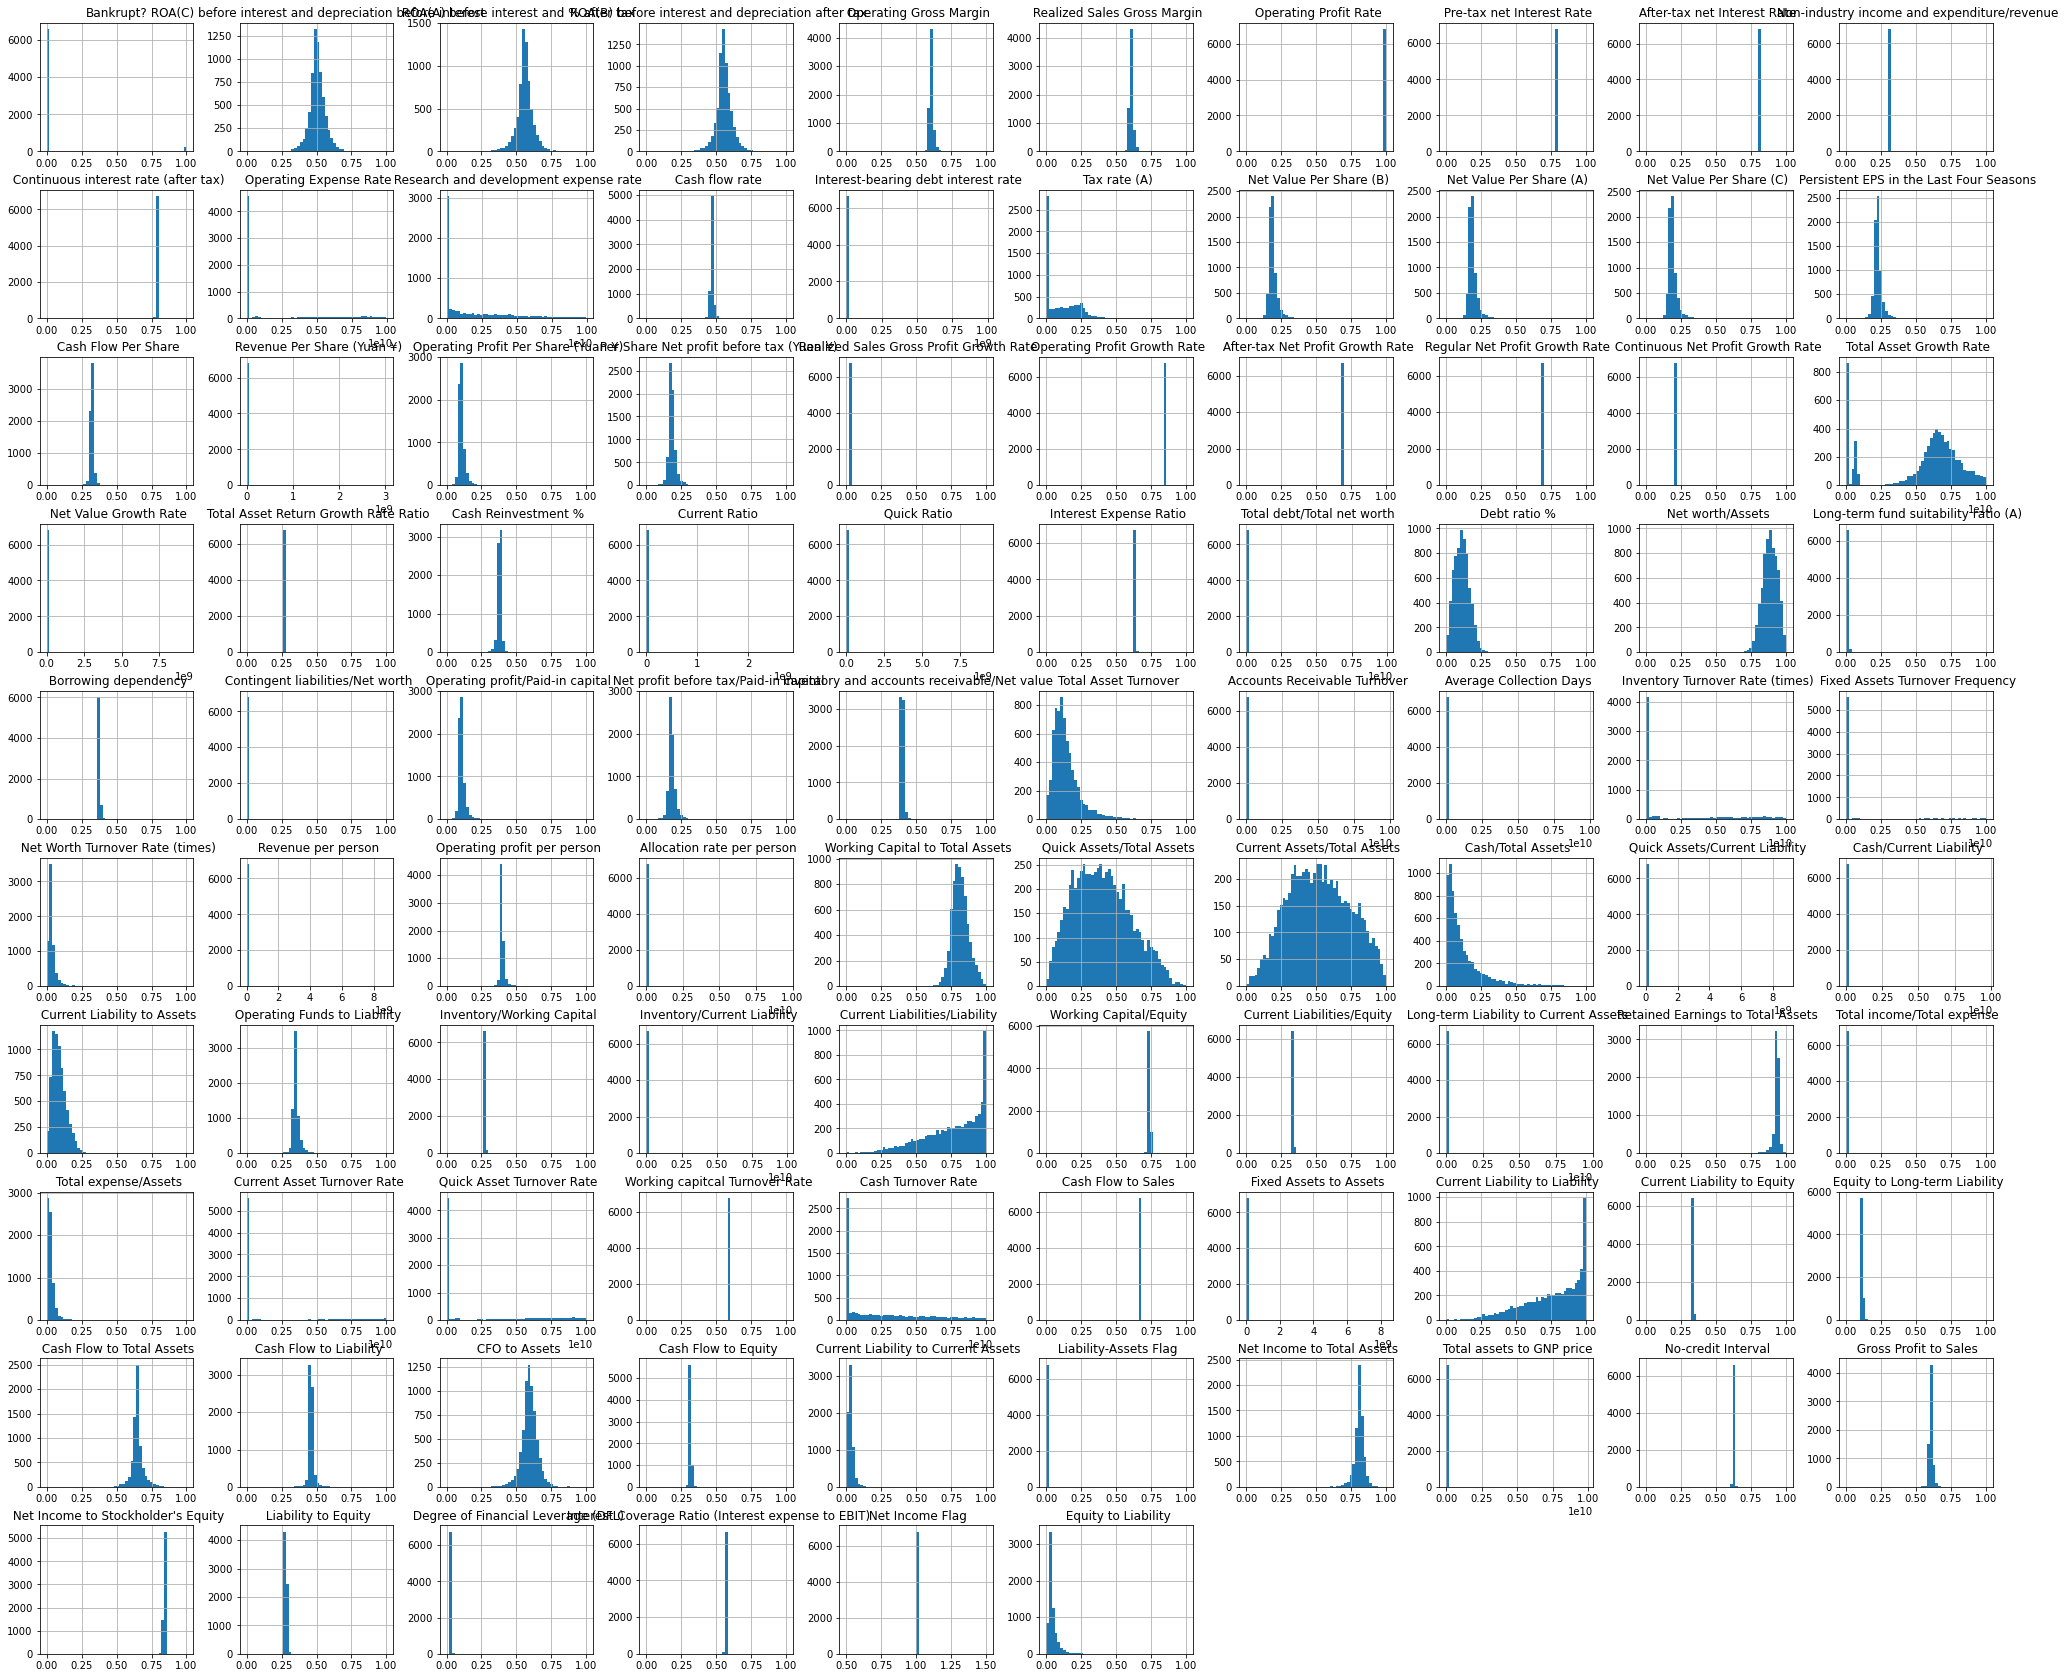

<Figure size 432x288 with 0 Axes>

In [9]:
df.hist(figsize = (35,30), bins = 50)
plt.show()
plt.savefig('./images/hist_df.jpg')

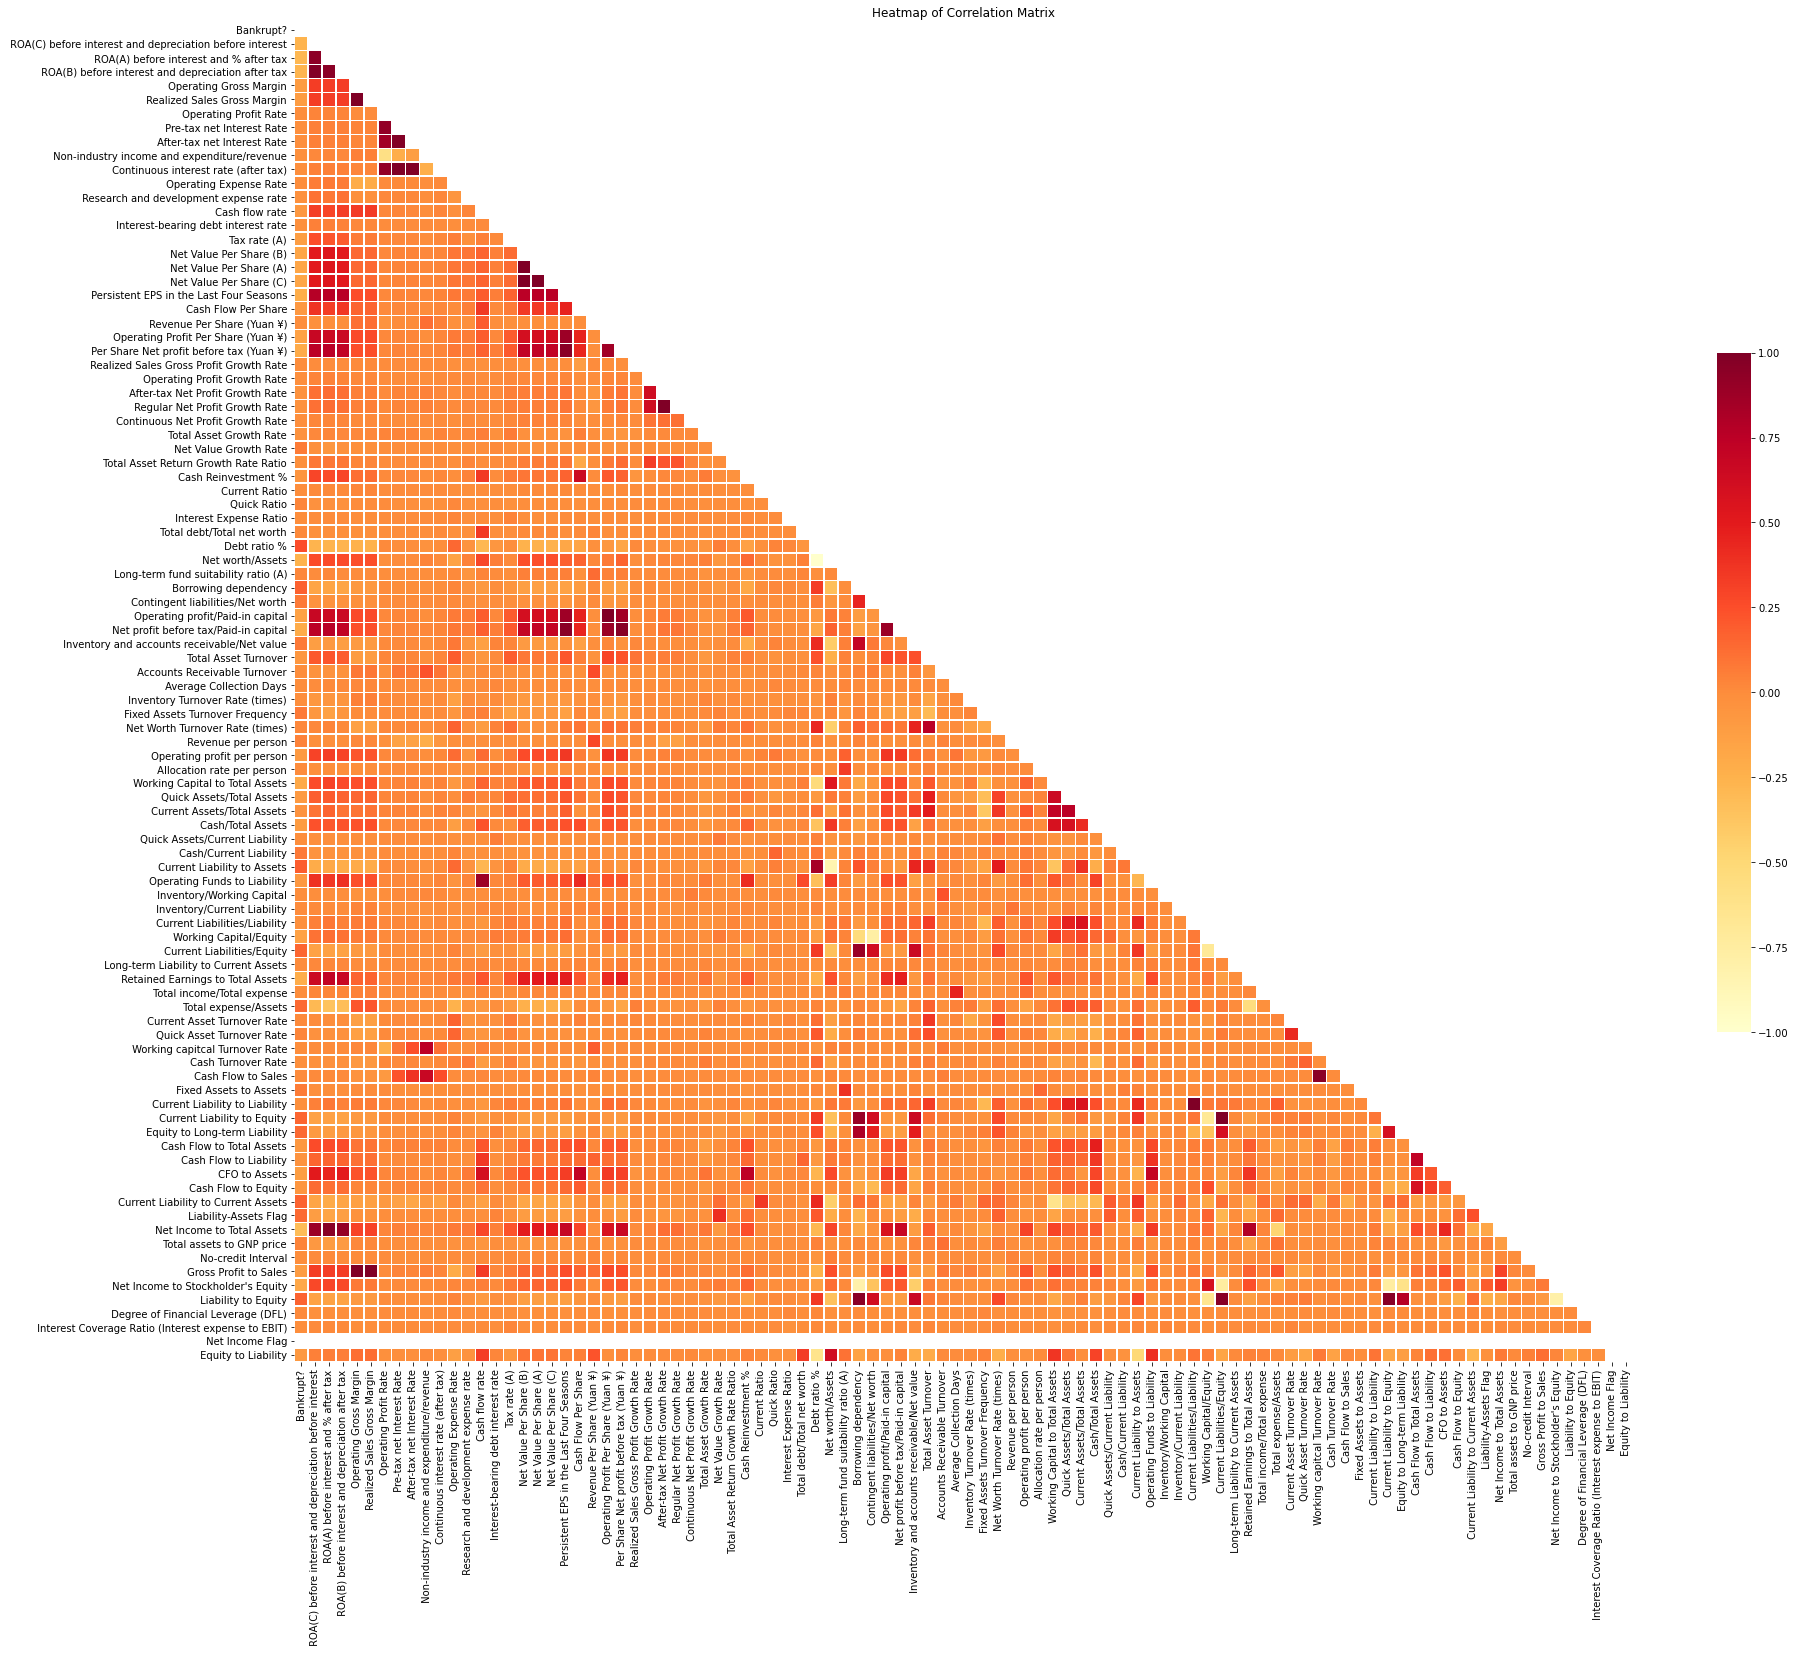

In [10]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(30,25))

sns.heatmap(data=corr, mask=np.triu(np.ones_like(corr, dtype=bool)),
            ax=ax, cmap='YlOrRd', #annot=True, 
            center=0, vmin=-1, vmax=1, square=True,
            linewidths=.5, 
            cbar_kws={"shrink": .5})

ax.set_title("Heatmap of Correlation Matrix");


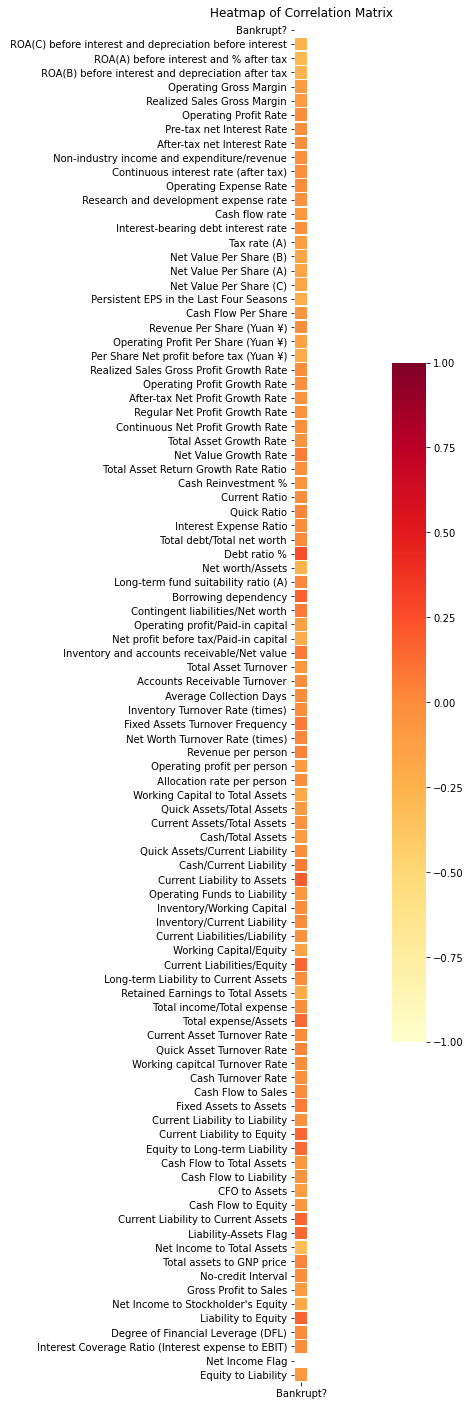

In [11]:
corr2 = df.corr()

fig, ax = plt.subplots(figsize=(30,25))

sns.heatmap(data=corr2[['Bankrupt?']], mask=np.triu(np.ones_like(corr2[['Bankrupt?']], dtype=bool)),
            ax=ax, cmap='YlOrRd', #annot=True, 
            center=0, vmin=-1, vmax=1, square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})

ax.set_title("Heatmap of Correlation Matrix");


In [12]:
df.iloc[:, 94:95].value_counts()

 Net Income Flag
1                   6819
dtype: int64

- all values are 1 so we'll drop Net Income Flag
- we will also use the top 10 correlated features in our intiial models and compare against using all

In [13]:
df.drop(' Net Income Flag', axis=1, inplace=True)

#### Exploring outliers using boxplot

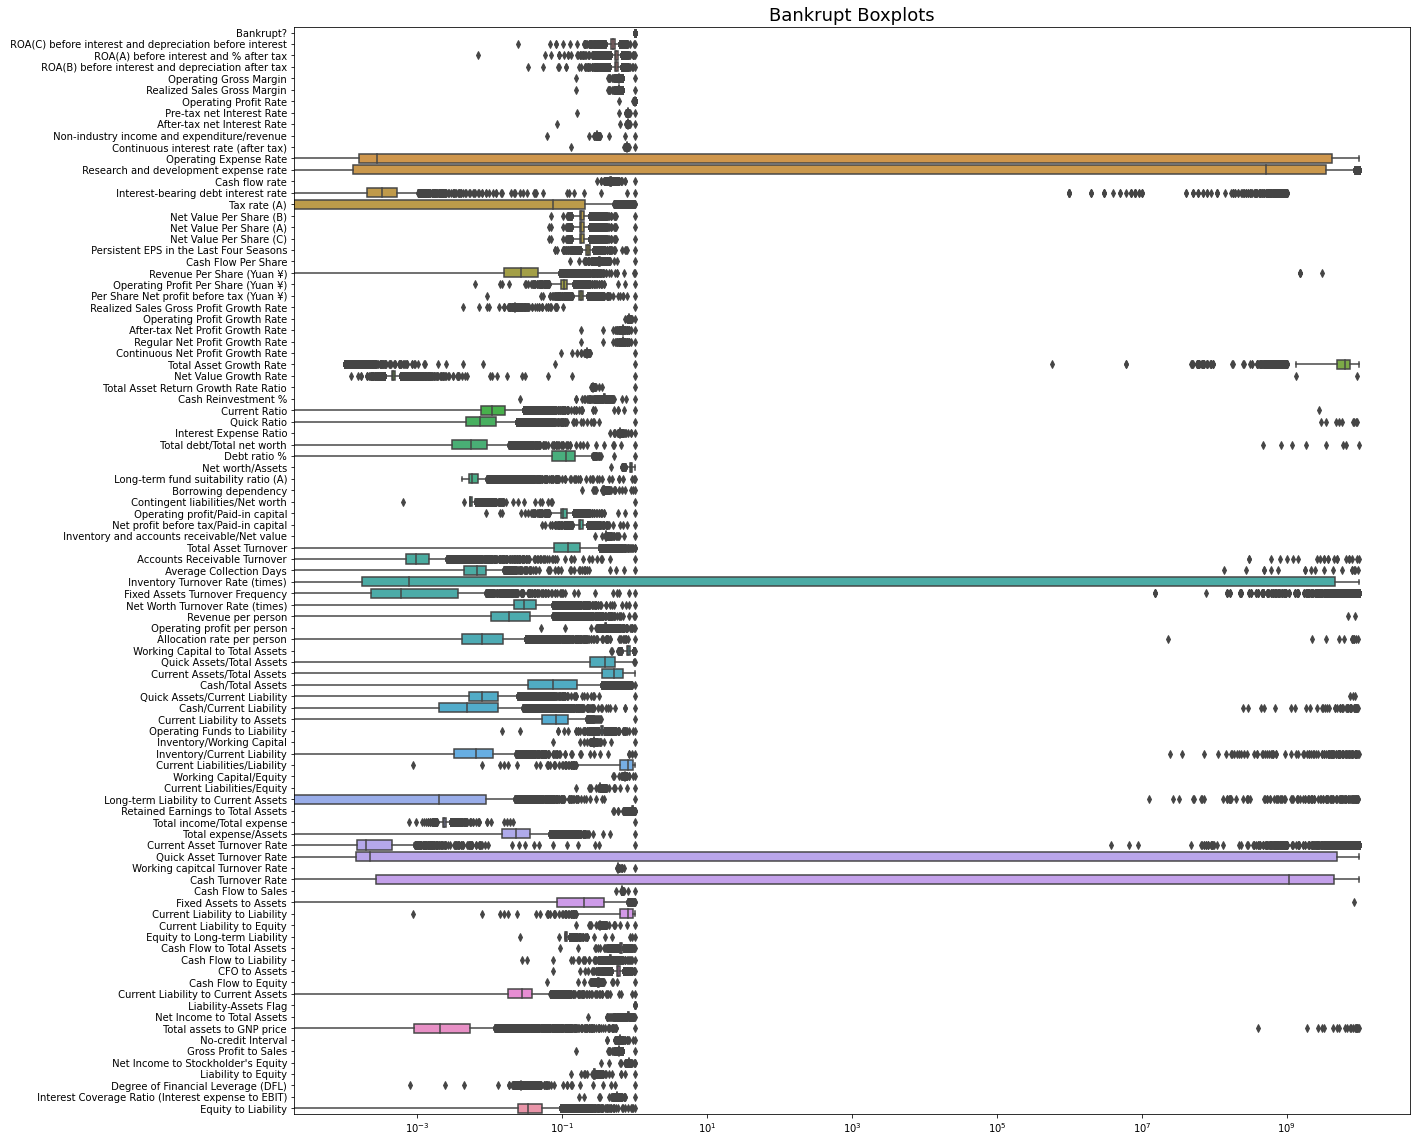

In [14]:
fig,ax = plt.subplots(figsize = (20,20))

ax =sns.boxplot(data = df, orient="h")
ax.set_title('Bankrupt Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

#### Removing outliers

In [15]:
def eli_outliers(col, col_name, df):
    print(col_name)
    q25, q75 = np.percentile(col, 25), np.percentile(col, 75)
    iqr = q75 - q25
    print(f"Q25 is {q25} and Q75 is {q75} | iqr is {iqr}")
    
    cutoff = iqr * 1.5
    lower_cutoff, upper_cutoff = q25 - cutoff, q75 + cutoff
    print(f"Cutoff is {cutoff} | Lower is {lower_cutoff} and Upper is {upper_cutoff}")
    
    outliers = [x for x in col if (x<lower_cutoff) or (x>upper_cutoff)]
    print(f"Number of outliers is {len(outliers)}")
    
    df = df.drop(df[(df[col_name] > upper_cutoff) | (df[col_name] < lower_cutoff)].index)
    print('-' * 65)
    
    return df

In [16]:
for col in df:
    df_cleaned = eli_outliers(df[col], str(col), df)


Bankrupt?
Q25 is 0.0 and Q75 is 0.0 | iqr is 0.0
Cutoff is 0.0 | Lower is 0.0 and Upper is 0.0
Number of outliers is 220
-----------------------------------------------------------------
 ROA(C) before interest and depreciation before interest
Q25 is 0.47652708038804703 and Q75 is 0.535562813825379 | iqr is 0.05903573343733193
Cutoff is 0.08855360015599789 | Lower is 0.38797348023204914 and Upper is 0.6241164139813768
Number of outliers is 391
-----------------------------------------------------------------
 ROA(A) before interest and % after tax
Q25 is 0.53554295682512 and Q75 is 0.58915721761884 | iqr is 0.05361426079372
Cutoff is 0.08042139119058 | Lower is 0.45512156563454 and Upper is 0.66957860880942
Number of outliers is 561
-----------------------------------------------------------------
 ROA(B) before interest and depreciation after tax
Q25 is 0.5272766208041121 and Q75 is 0.584105144815033 | iqr is 0.05682852401092087
Cutoff is 0.0852427860163813 | Lower is 0.44203383478773

Q25 is 0.00300704912501482 and Q75 is 0.009273292661797026 | iqr is 0.006266243536782206
Cutoff is 0.009399365305173308 | Lower is -0.006392316180158488 and Upper is 0.018672657966970332
Number of outliers is 407
-----------------------------------------------------------------
 Debt ratio %
Q25 is 0.0728905281615624 and Q75 is 0.14880430510626702 | iqr is 0.07591377694470462
Cutoff is 0.11387066541705693 | Lower is -0.04098013725549453 and Upper is 0.26267497052332395
Number of outliers is 30
-----------------------------------------------------------------
 Net worth/Assets
Q25 is 0.8511956948937329 and Q75 is 0.927109471838438 | iqr is 0.07591377694470502
Cutoff is 0.11387066541705754 | Lower is 0.7373250294766753 and Upper is 1.0409801372554954
Number of outliers is 30
-----------------------------------------------------------------
 Long-term fund suitability ratio (A)
Q25 is 0.005243683690608274 and Q75 is 0.006847432465535919 | iqr is 0.001603748774927645
Cutoff is 0.0024056231

Q25 is 0.6269807662218725 and Q75 is 0.9420266937000692 | iqr is 0.3150459274781967
Cutoff is 0.47256889121729506 | Lower is 0.15441187500457743 and Upper is 1.4145955849173641
Number of outliers is 40
-----------------------------------------------------------------
 Working Capital/Equity
Q25 is 0.7336118185643419 and Q75 is 0.738559910578823 | iqr is 0.004948092014481098
Cutoff is 0.007422138021721647 | Lower is 0.7261896805426202 and Upper is 0.7459820486005446
Number of outliers is 153
-----------------------------------------------------------------
 Current Liabilities/Equity
Q25 is 0.328095841686878 and Q75 is 0.332322404809702 | iqr is 0.00422656312282399
Cutoff is 0.006339844684235985 | Lower is 0.321755997002642 and Upper is 0.338662249493938
Number of outliers is 480
-----------------------------------------------------------------
 Long-term Liability to Current Assets
Q25 is 0.0 and Q75 is 0.00900594594425662 | iqr is 0.00900594594425662
Cutoff is 0.013508918916384931 | L

In [17]:
print(df_cleaned['Bankrupt?'].value_counts())
print(f'Shape {df_cleaned.shape}')

0    6052
1     218
Name: Bankrupt?, dtype: int64
Shape (6270, 95)


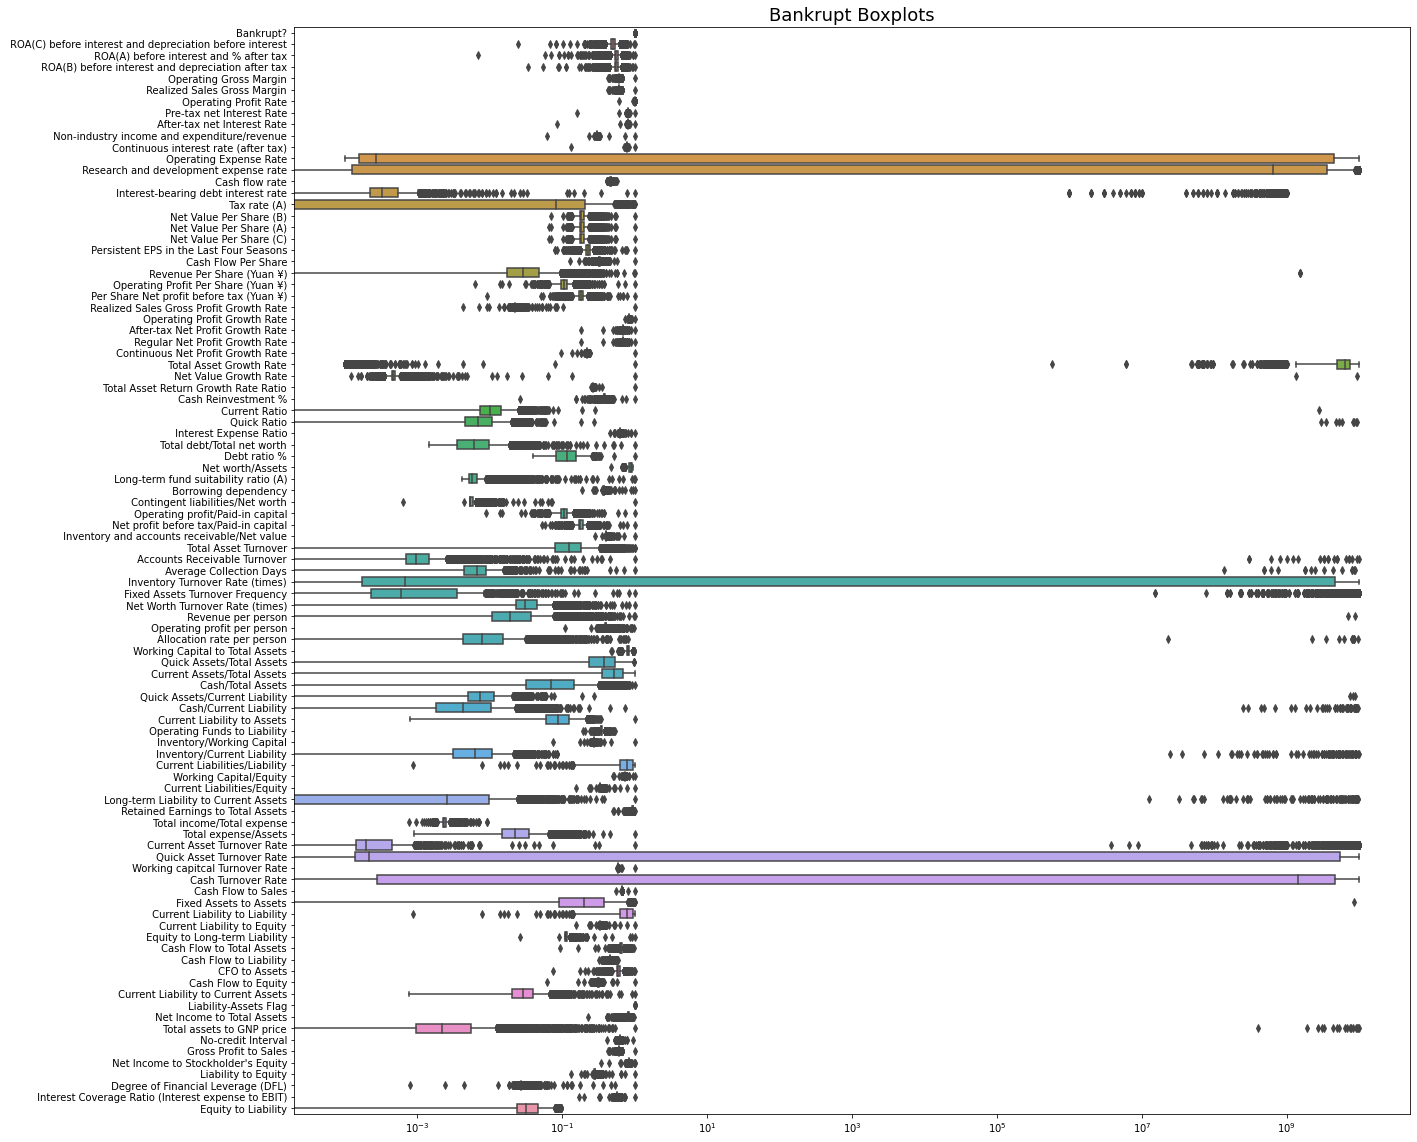

In [18]:
fig,ax = plt.subplots(figsize = (20,20))

ax =sns.boxplot(data = df_cleaned, orient="h")
ax.set_title('Bankrupt Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()


#### Exploring features containing debt or cash in the feature name as we have 96 columns and want to isolate ones we think are relevant

In [19]:
matches = ["debt"]
debt_col = [col for col in df_cleaned.columns if any(x in col.lower() for x in matches)]
debt_col

[' Interest-bearing debt interest rate',
 ' Total debt/Total net worth',
 ' Debt ratio %']

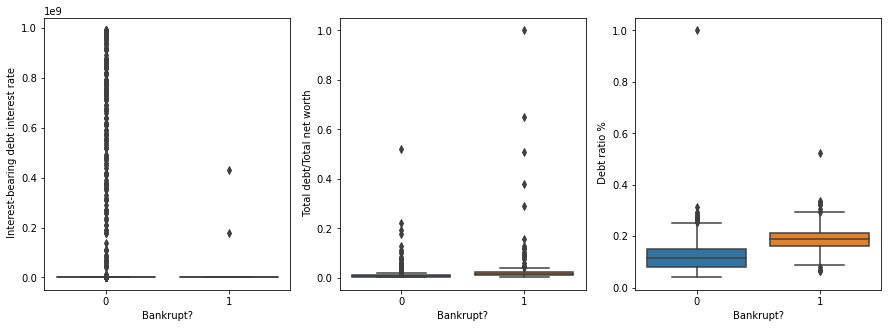

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax = sns.boxplot(x='Bankrupt?', y=' Interest-bearing debt interest rate', data=df_cleaned, ax=ax1)
ax = sns.boxplot(x='Bankrupt?', y=' Total debt/Total net worth', data=df_cleaned, ax=ax2)
ax = sns.boxplot(x='Bankrupt?', y=' Debt ratio %', data=df_cleaned, ax=ax3)

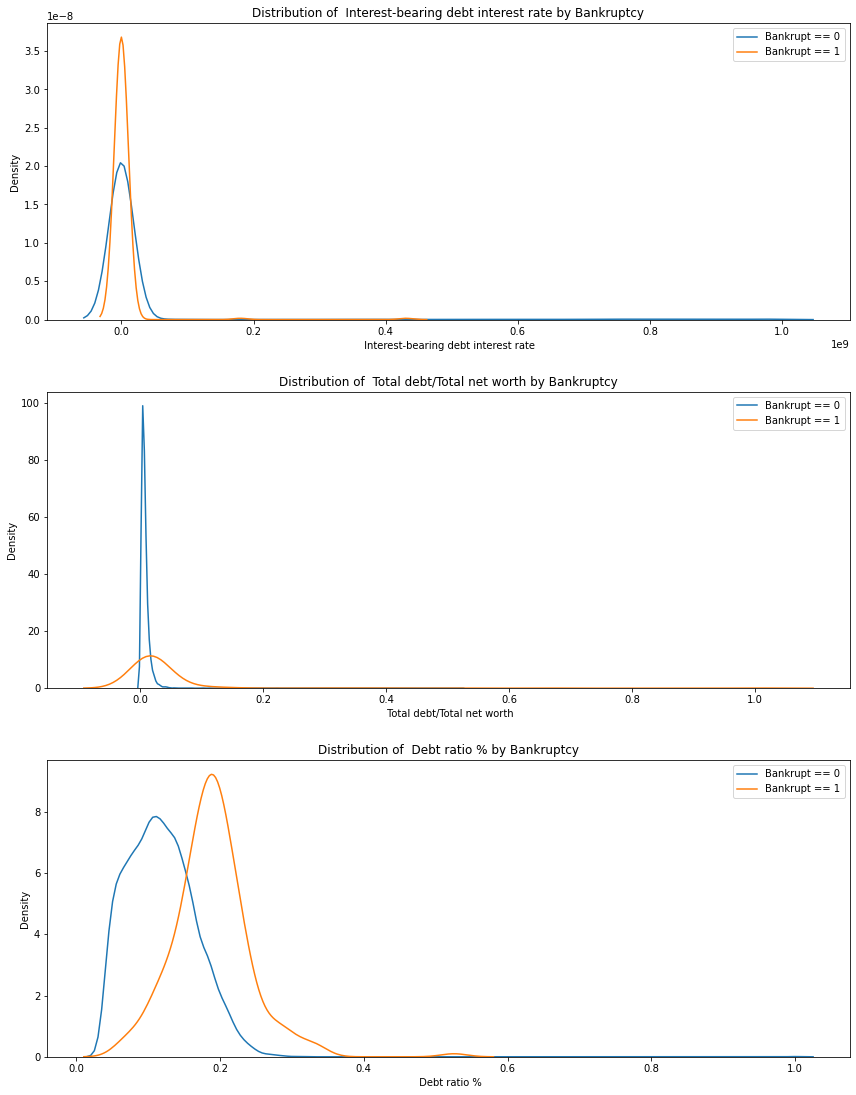

In [21]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate([' Interest-bearing debt interest rate', ' Total debt/Total net worth', ' Debt ratio %']):
    
    # create a new subplot for each feature
    plt.subplot(4, 1, i + 1)
    
    ax = sns.kdeplot(df_cleaned.loc[df_cleaned['Bankrupt?'] == 0, feature], label = 'Bankrupt == 0')
    ax = sns.kdeplot(df_cleaned.loc[df_cleaned['Bankrupt?'] == 1, feature], label = 'Bankrupt == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Bankruptcy' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    ax.legend()
    
plt.tight_layout(h_pad = 2.5)


#### Exploring top correlating features

In [22]:
top_cor_col = corr2[["Bankrupt?"]].apply(abs).sort_values('Bankrupt?', ascending=False).iloc[1:11,:].index
list(top_cor_col)

[' Net Income to Total Assets',
 ' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' ROA(C) before interest and depreciation before interest',
 ' Net worth/Assets',
 ' Debt ratio %',
 ' Persistent EPS in the Last Four Seasons',
 ' Retained Earnings to Total Assets',
 ' Net profit before tax/Paid-in capital',
 ' Per Share Net profit before tax (Yuan ¥)']

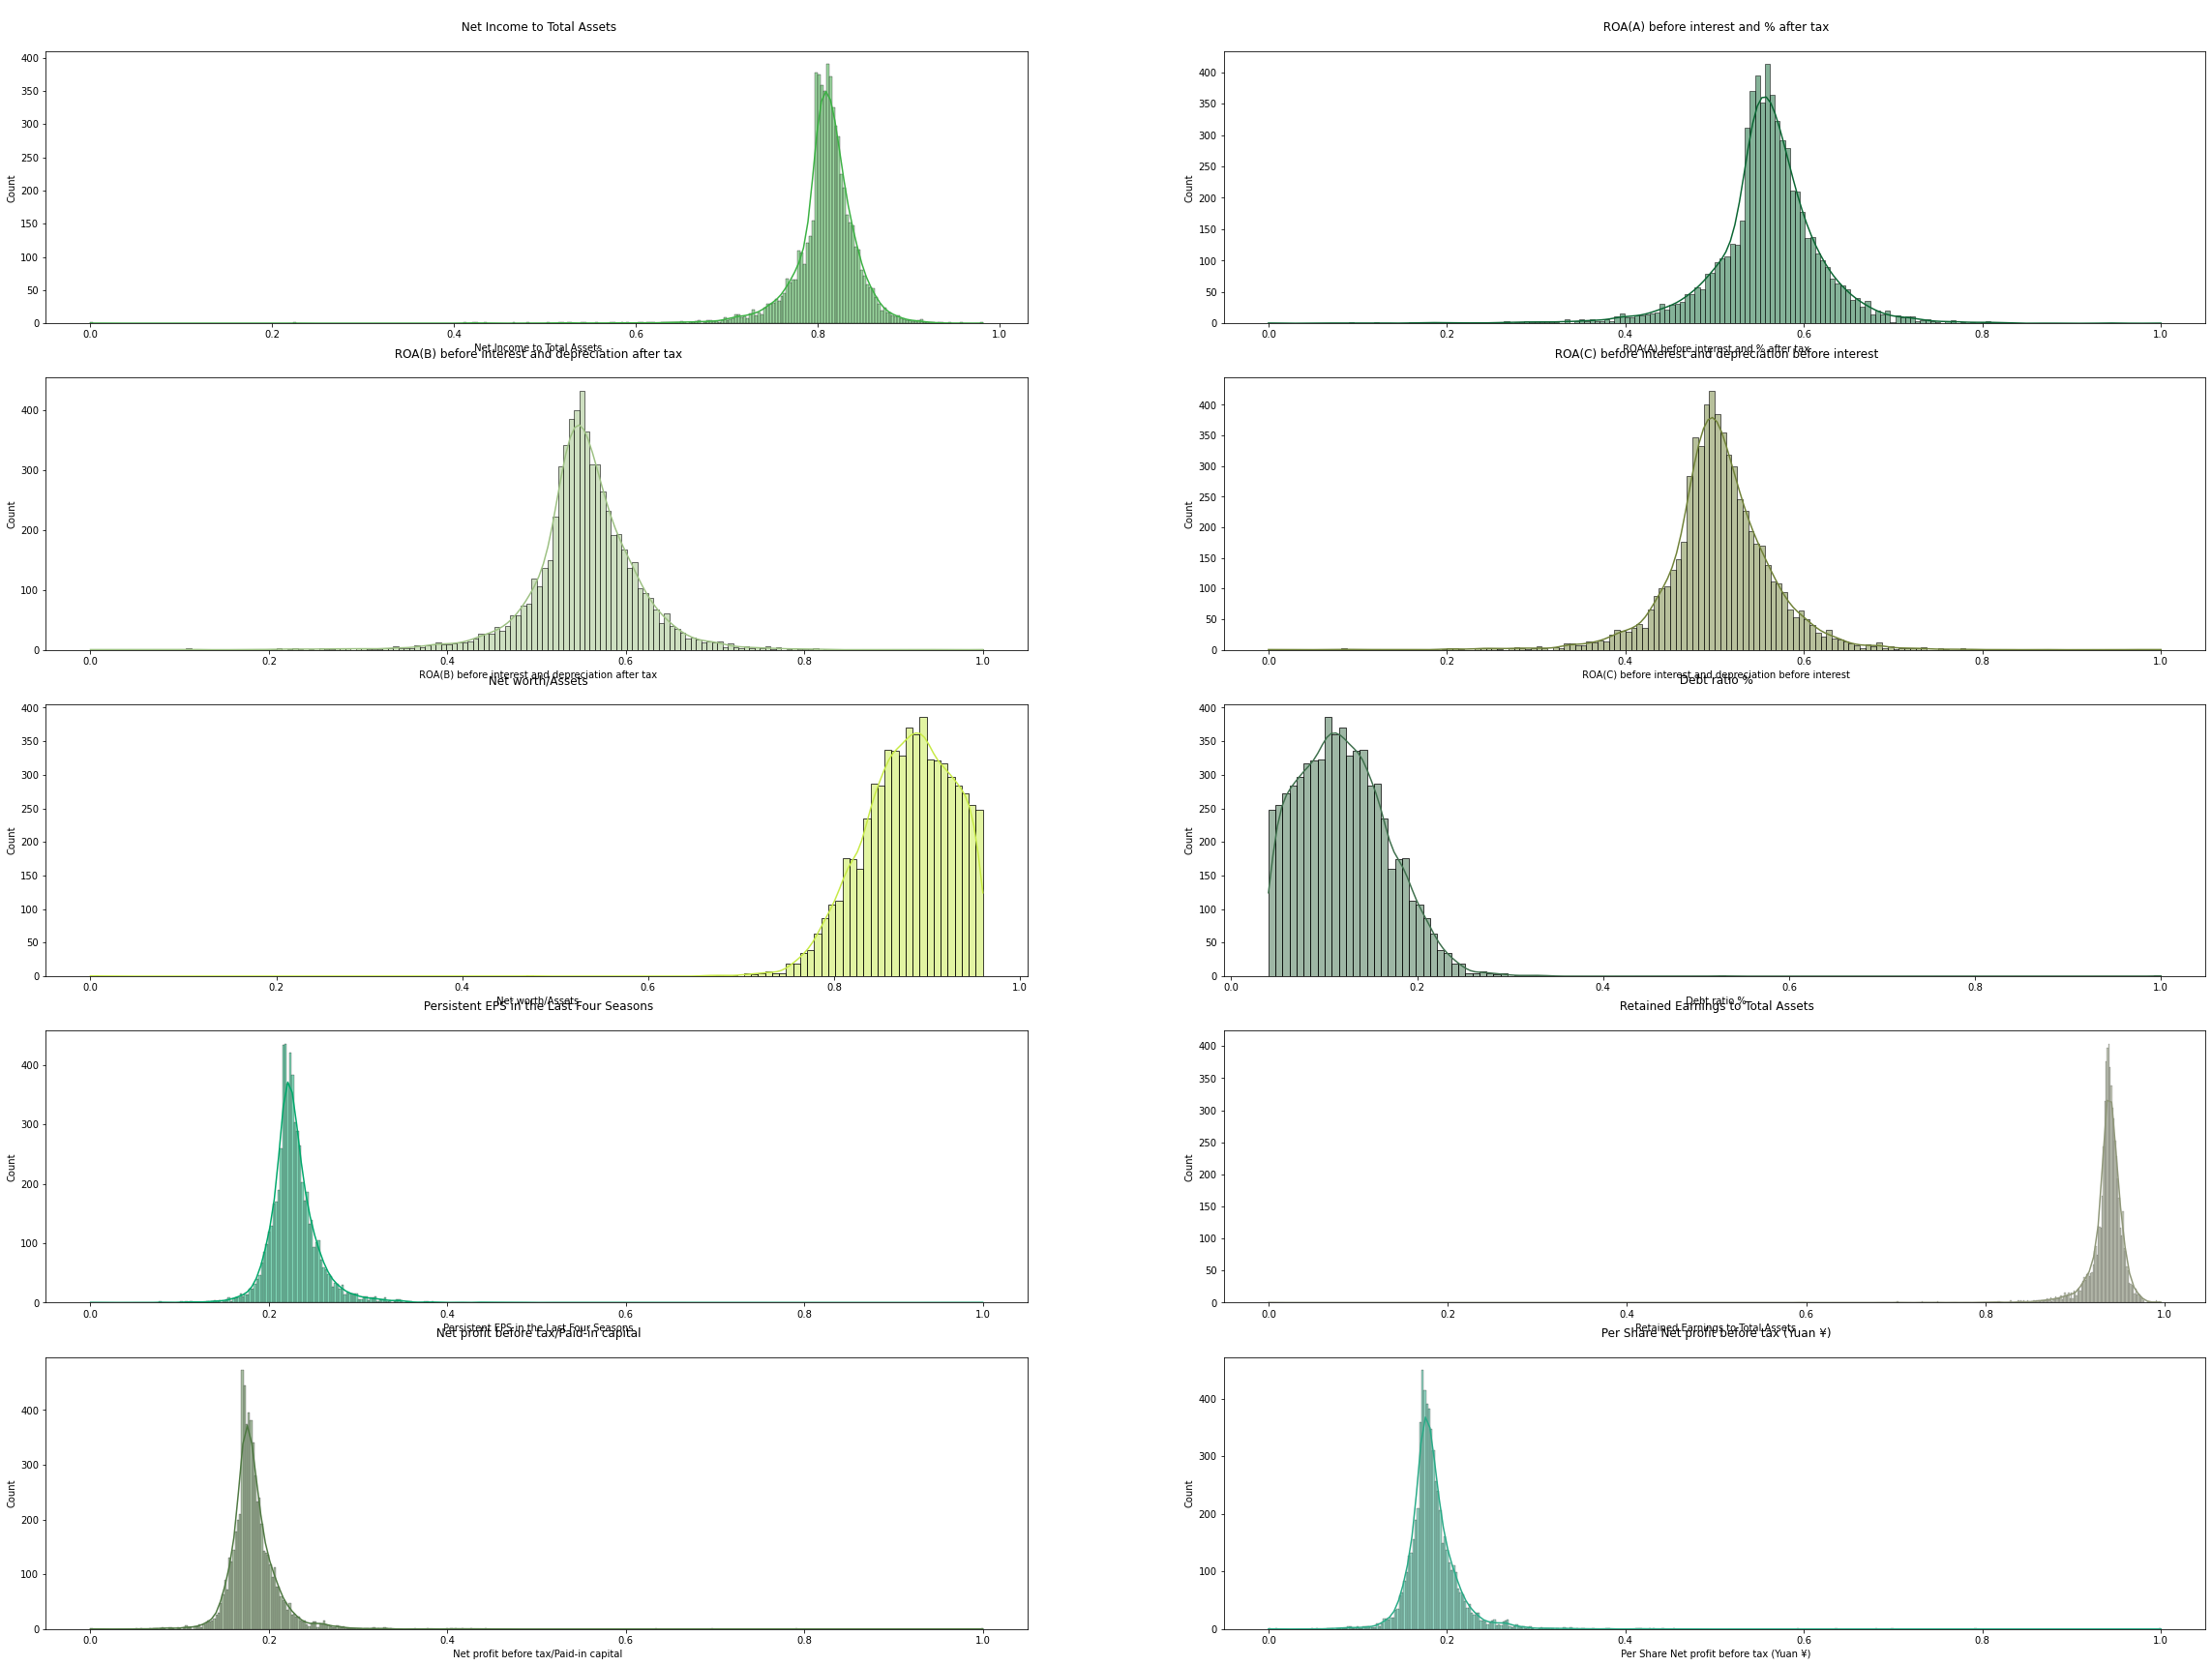

In [23]:
fig, ax = plt.subplots(figsize=(40,30), ncols=2, nrows=5)

colors = ['#3BB143', '#0B6633', '#9DC183', '#708238', '#C7EA46',
          '#3F704D', '#00A86B', '#8F9779', '#4F7942', '#29AB87']

for i, column in enumerate(df_cleaned[list(top_cor_col)]):
    sns.histplot(df_cleaned[column], ax=ax[i//2, i%2], kde=True, color=colors[i])
    ax[i//2, i%2].set_title('\n' + column + '\n')

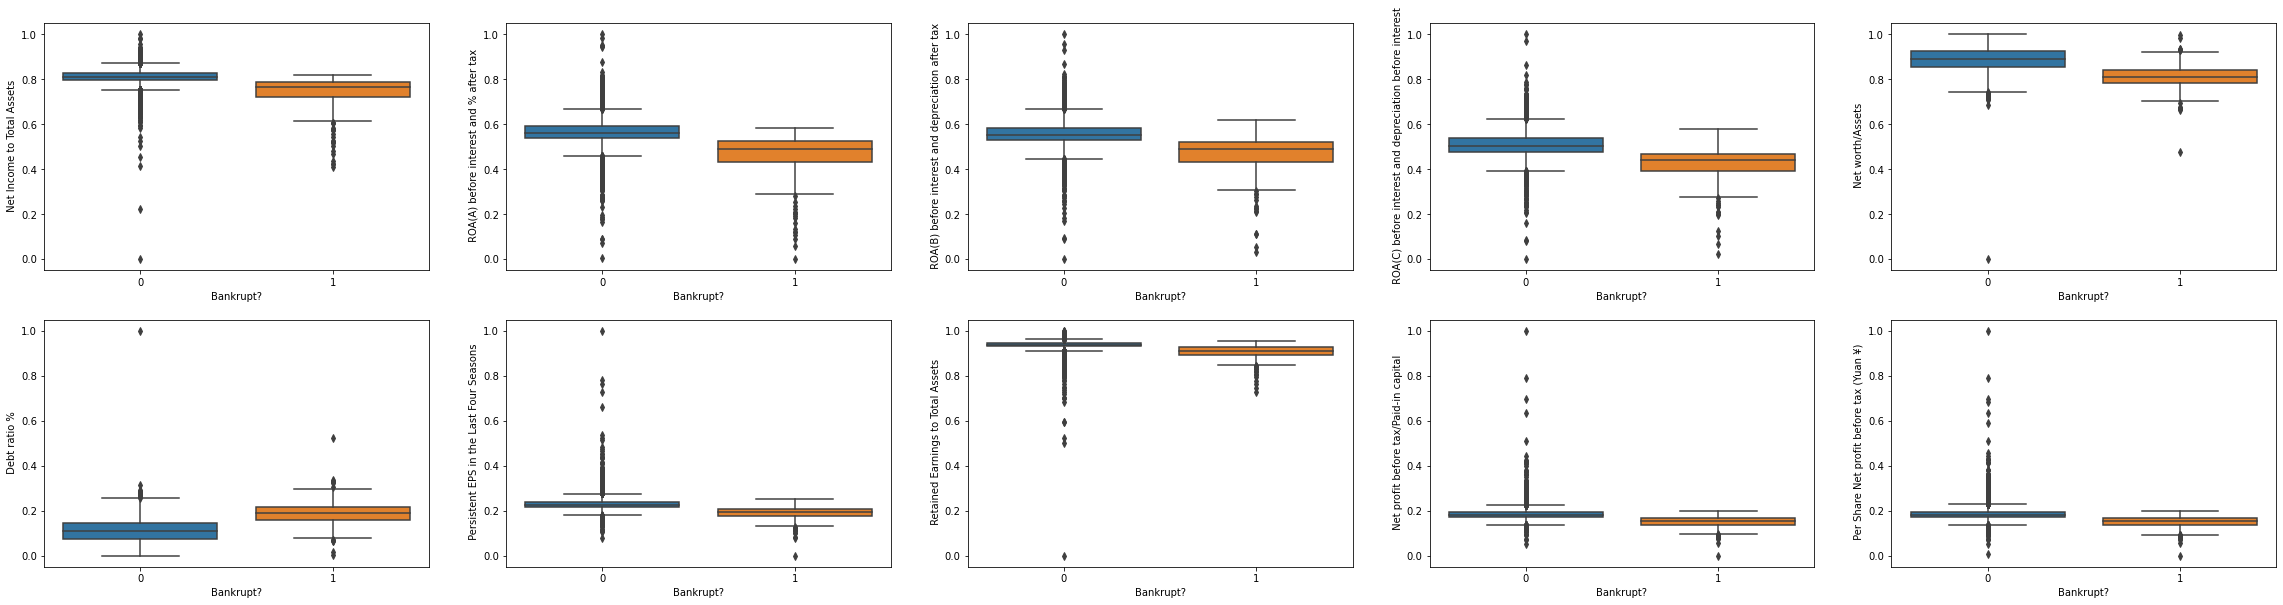

In [24]:
fig, ax = plt.subplots(figsize=(40, 10), ncols=5, nrows=2)

for i, col in enumerate(df_cleaned[list(top_cor_col)]):
    sns.boxplot(x='Bankrupt?', y=col, data=df, ax=ax[i//5, i%5])

#### Distribution of the 10 features of 5 of the companies that went bankrupt

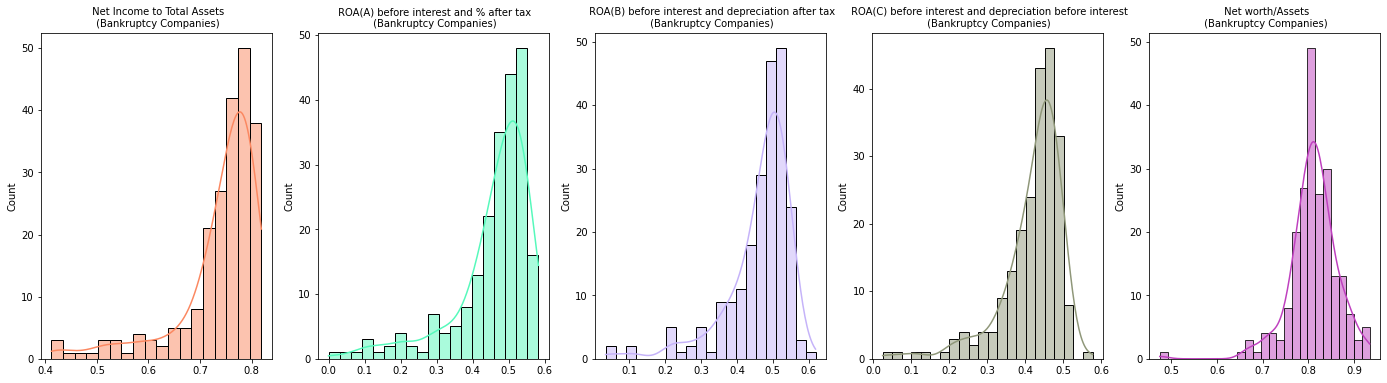

In [25]:
fig, ax = plt.subplots(1,5, figsize=(24, 6))
colors2 = ['#FB8861', '#56F9BB', '#C5B3F9', '#8F9779', '#bf40bf']

for i, col in enumerate(df_cleaned[list(top_cor_col[:5])]):
    bankrupt = df_cleaned[col].loc[df_cleaned['Bankrupt?'] == 1].values
    sns.histplot(bankrupt, ax=ax[i], kde=True, color=colors2[i])
    ax[i].set_title(col + '\n (Bankruptcy Companies)', fontsize=10)


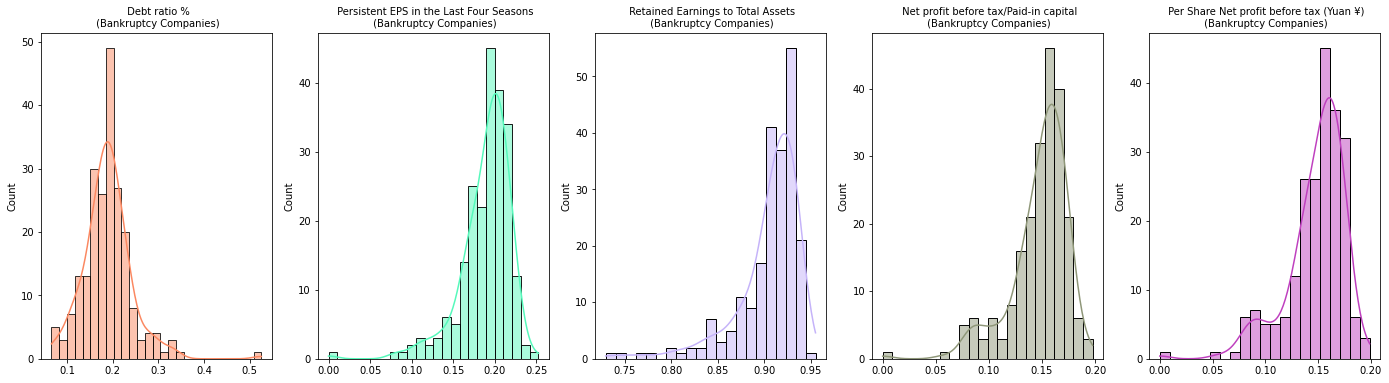

In [26]:
fig, ax = plt.subplots(1,5, figsize=(24, 6))
colors2 = ['#FB8861', '#56F9BB', '#C5B3F9', '#8F9779', '#bf40bf']

for i, col in enumerate(df_cleaned[list(top_cor_col[5:])]):
    bankrupt = df_cleaned[col].loc[df_cleaned['Bankrupt?'] == 1].values
    sns.histplot(bankrupt, ax=ax[i], kde=True, color=colors2[i])
    ax[i].set_title(col + '\n (Bankruptcy Companies)', fontsize=10)


### Splitting the Data

Below we will split our target from our predictors and train test split in order to leave a sample of the data for our model to test on at the end. Our dataset is about 6000 rows so we will keep our test size at 20% and train on 80% of the data.

In [27]:
X = df_cleaned.drop('Bankrupt?', axis=1)
y = df_cleaned['Bankrupt?']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=4, 
                                                    stratify=y, 
                                                    test_size=.2)

In [29]:
stratified_kfold = StratifiedKFold(n_splits=5, 
                                   random_state=4, 
                                   shuffle=True)

### First logistic regression model with debt features 

#### Subsetting the training data with the debt features
- we want to start with a simple model with features we believe might have an impact on bankruptcy for companies.
- we implemented Standard Scaler into our pipeline because the column data are not all on the same scale and it would transform the data through standardizing

In [30]:
debt_col

[' Interest-bearing debt interest rate',
 ' Total debt/Total net worth',
 ' Debt ratio %']

In [31]:
X_train_debt = X_train[debt_col]
X_test_debt = X_test[debt_col]

In [32]:
debt_steps = [('ss', StandardScaler()),
             ('debt', LogisticRegression(random_state=4))]

In [33]:
debt_pipeline = Pipeline(debt_steps)
debt_pipeline.fit(X_train_debt, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('debt', LogisticRegression(random_state=4))])

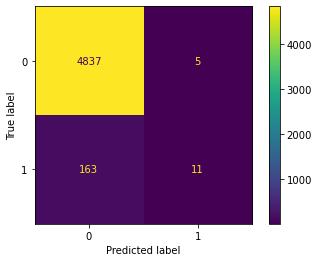

In [34]:
plot_confusion_matrix(debt_pipeline, X_train_debt, y_train)
plt.savefig('./images/conf_matrix_debt_train');

In [35]:
print(classification_report(y_train, debt_pipeline.predict(X_train_debt)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4842
           1       0.69      0.06      0.12       174

    accuracy                           0.97      5016
   macro avg       0.83      0.53      0.55      5016
weighted avg       0.96      0.97      0.95      5016



#### Our baseline model recall and precision score

In [36]:
precision_score_base = precision_score(y_train, debt_pipeline.predict(X_train_debt))
recall_score_base = recall_score(y_train, debt_pipeline.predict(X_train_debt))

We will add our scores into these dictionaries as we iterate.

In [37]:
recall_scores = {}
precision_scores = {}

In [38]:
recall_scores['Baseline'] = {'Train':recall_score_base, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0}}

In [39]:
precision_scores['Baseline'] = {'Train':precision_score_base, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0}}

#### Analysis of our Logistic Regression model using debt/liability features
In this model, we were able to achieve a precision score of 69% and a recall score of 6%. We are unable to succesfully predict if a company will go bankrupt. This might be due to the imbalance in our targe minority class. We will further explore other features that are correlated with our target and class balancing to see if our model improves. 

### Logistic Regression Model with top 10 features

#### Subsetting the training data with the top 10 features
- we want to explore if the correlated features would yield a better fitting model

In [40]:
X_train_top_10 = X_train[top_cor_col]
X_test_top_10 = X_test[top_cor_col]

In [41]:
top_10_steps = [('ss', StandardScaler()),
             ('top_10', LogisticRegression(random_state=4))]

In [42]:
top_10_pipeline = Pipeline(top_10_steps)

In [43]:
top_10_cv = cross_validate(top_10_pipeline, 
                           X_train_top_10, y_train, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring=['precision', 'neg_log_loss'])

In [44]:
top_10_cv

{'fit_time': array([0.08876228, 0.08577132, 0.07878923, 0.07480335, 0.08277941]),
 'score_time': array([0.01097035, 0.01795268, 0.01695395, 0.01395917, 0.01695538]),
 'test_precision': array([0.57142857, 0.54545455, 0.53333333, 0.21052632, 1.        ]),
 'test_neg_log_loss': array([-0.1030833 , -0.11551538, -0.10776766, -0.1322051 , -0.09698759])}

In [45]:
cv10_ = cross_val_score(top_10_pipeline, 
                           X_train_top_10, y_train, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='precision')

In [46]:
cv10_.mean()

0.5721485532011847

In [47]:
top_10_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('top_10', LogisticRegression(random_state=4))])

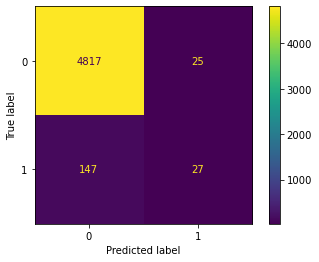

In [48]:
plot_confusion_matrix(top_10_pipeline, X_train_top_10, y_train);

In [49]:
print(classification_report(y_train, top_10_pipeline.predict(X_train_top_10)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4842
           1       0.52      0.16      0.24       174

    accuracy                           0.97      5016
   macro avg       0.74      0.58      0.61      5016
weighted avg       0.95      0.97      0.96      5016



In [50]:
recall_score_top_10 = recall_score(y_train, top_10_pipeline.predict(X_train_top_10))
recall_scores['Top 10'] = {'Train':recall_score_top_10, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0}}

In [51]:
precision_score_top_10 = precision_score(y_train, top_10_pipeline.predict(X_train_top_10))
precision_scores['Top 10'] = {'Train':precision_score_top_10, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0}}

#### Analysis of model with top 10 features
Like our first model, we were unable to correctly predict many of the comopanies that went bankrupt. This might be due to the imbalance in the dataset which we will explore next.

### Logistic regression with Class Weight 
- We will use grid search to find the best class weights to rebalance the minority class and majority class while continuing to use top 10 features.

In [52]:
cw_steps = [('ss', StandardScaler()),
             ('cw', LogisticRegression(random_state=4))]

In [53]:
cw_pipeline = Pipeline(cw_steps)
cw_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('cw', LogisticRegression(random_state=4))])

In [54]:
stratified_kfold = StratifiedKFold(n_splits=5,
                                  shuffle=True,
                                  random_state=4)

weights = np.linspace(0.0,0.99,200)

In [55]:
cw_grid = {'cw__class_weight':[{0:x, 1:1.0-x} for x in weights]}

In [56]:
cw_grid_search = GridSearchCV(estimator=cw_pipeline,
                                param_grid=cw_grid,
                                scoring=['precision', 'neg_log_loss'],
                                cv=stratified_kfold,
                                n_jobs=-1,
                                refit='precision')

In [57]:
cw_grid_search.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('cw',
                                        LogisticRegression(random_state=4))]),
             n_jobs=-1,
             param_grid={'cw__class_weight': [{0: 0.0, 1: 1.0},
                                              {0: 0.004974874371859297,
                                               1: 0.9950251256281407},
                                              {0: 0.009949748743718593,
                                               1: 0.9900502512562814},
                                              {0: 0.014924623115577889,
                                               1: 0.98507537...
                                              {0: 0.11442211055276383,
                                               1: 0.8855778894472361},
                                              {0: 0.11939698492462311,
            

In [58]:
cw_grid_search.best_params_

{'cw__class_weight': {0: 0.870603015075377, 1: 0.12939698492462304}}

Text(0.5, 1.0, 'Scoring for different class weights')

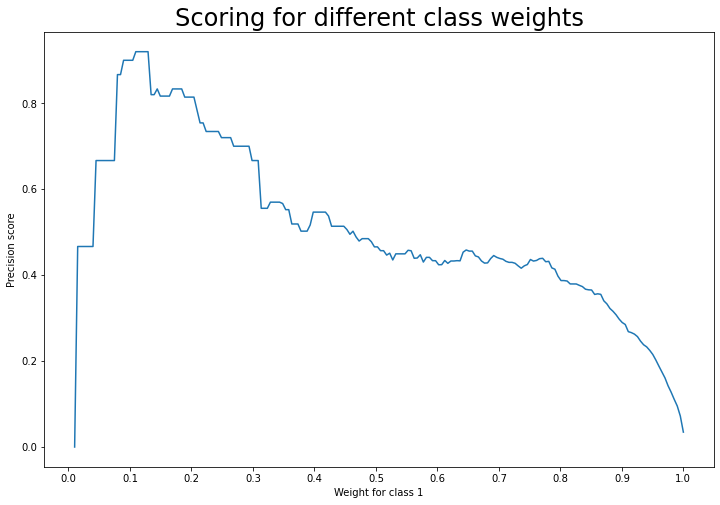

In [59]:
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': cw_grid_search.cv_results_['mean_test_precision'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('Precision score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)


In [60]:
best_cw_steps = [('ss', StandardScaler()),
             ('cw', LogisticRegression(random_state=4, class_weight={0: 0.870603015075377, 1: 0.12939698492462304}))]

In [61]:
best_cw_pipeline = Pipeline(best_cw_steps)

In [62]:
best_cw_cv = cross_validate(best_cw_pipeline, 
                            X_train_top_10, y_train, 
                            cv=stratified_kfold, 
                            n_jobs=-1, 
                            scoring=['precision', 'neg_log_loss'])

In [63]:
best_cw_cv

{'fit_time': array([0.08477521, 0.0718112 , 0.06083679, 0.07679605, 0.05784559]),
 'score_time': array([0.01296353, 0.0099721 , 0.01596045, 0.01096892, 0.01097369]),
 'test_precision': array([1. , 1. , 0.6, 1. , 1. ]),
 'test_neg_log_loss': array([-0.15314538, -0.13971449, -0.14612865, -0.12529045, -0.1409078 ])}

In [64]:
best_cw_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('cw',
                 LogisticRegression(class_weight={0: 0.870603015075377,
                                                  1: 0.12939698492462304},
                                    random_state=4))])

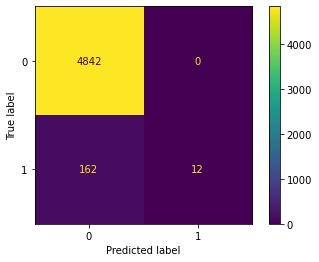

In [65]:
plot_confusion_matrix(best_cw_pipeline, X_train_top_10, y_train);

In [66]:
print(classification_report(y_train, best_cw_pipeline.predict(X_train_top_10)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4842
           1       1.00      0.07      0.13       174

    accuracy                           0.97      5016
   macro avg       0.98      0.53      0.56      5016
weighted avg       0.97      0.97      0.95      5016



In [67]:
recall_score_best_cw = recall_score(y_train, best_cw_pipeline.predict(X_train_top_10))
recall_scores['Class Weight'] = {'Train':recall_score_best_cw, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0}}

In [68]:
precision_score_best_cw = precision_score(y_train, best_cw_pipeline.predict(X_train_top_10))
precision_scores['Class Weight'] = {'Train':precision_score_best_cw, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0}}

#### Analysis of class weight rebalancing
In this model, we were able to extract the best class weights via grid search cross validation. We minimized our false positives but still not able to correctly predict if a company went bankrupt.

### Modelling with Oversampling and Undersampling
- we will be using an oversampling method, SMOTE, and an undersampling methods to rebalance the classes since our minority class is only 3% vs the majority class' 97%.

In [69]:
over_steps = [('smote', SMOTE(random_state=4)),
             ('ss', StandardScaler()),
             ('over', LogisticRegression(random_state=4))]

under_steps = [('undie', RandomUnderSampler(random_state=4)),
              ('ss', StandardScaler()),
              ('under', LogisticRegression(random_state=4))]

In [70]:
over_pipeline = imbpipeline(over_steps)
under_pipeline = imbpipeline(under_steps)

In [71]:
over_param_grid = {'over__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

under_param_grid = {'under__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [72]:
over_grid_search = GridSearchCV(estimator=over_pipeline,
                                param_grid=over_param_grid,
                                scoring=['precision', 'neg_log_loss'],
                                cv=stratified_kfold,
                                n_jobs=-1,
                                refit='precision')

In [73]:
under_grid_search = GridSearchCV(estimator=under_pipeline,
                                 param_grid=under_param_grid,
                                 scoring=['precision', 'neg_log_loss'],
                                 cv=stratified_kfold,
                                 n_jobs=-1,
                                 refit='precision')

In [74]:
over_grid_search.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4)),
                                       ('ss', StandardScaler()),
                                       ('over',
                                        LogisticRegression(random_state=4))]),
             n_jobs=-1,
             param_grid={'over__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit='precision', scoring=['precision', 'neg_log_loss'])

In [75]:
over_grid_search.score(X_train_top_10, y_train)

0.18969849246231155

In [76]:
under_grid_search.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('undie',
                                        RandomUnderSampler(random_state=4)),
                                       ('ss', StandardScaler()),
                                       ('under',
                                        LogisticRegression(random_state=4))]),
             n_jobs=-1,
             param_grid={'under__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit='precision', scoring=['precision', 'neg_log_loss'])

In [77]:
under_grid_search.score(X_train_top_10, y_train)

0.17445838084378562

In [78]:
over_grid_search.best_params_

{'over__C': 1000}

In [79]:
under_grid_search.best_params_

{'under__C': 10}

In [80]:
best_over_steps = [('smote', SMOTE(random_state=4)),
             ('ss', StandardScaler()),
             ('best_over_over', LogisticRegression(C=1000,
                                         random_state=4))]
best_under_steps = [('smote', SMOTE(random_state=4)),
             ('ss', StandardScaler()),
             ('best_under_under', LogisticRegression(C=10,
                                         random_state=4))]

In [81]:
best_over_pipeline = imbpipeline(best_over_steps)
best_under_pipeline = imbpipeline(best_under_steps)

In [82]:
best_over_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=4)), ('ss', StandardScaler()),
                ('best_over_over', LogisticRegression(C=1000, random_state=4))])

In [83]:
best_under_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=4)), ('ss', StandardScaler()),
                ('best_under_under', LogisticRegression(C=10, random_state=4))])

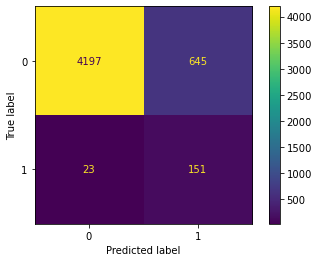

In [84]:
plot_confusion_matrix(best_over_pipeline, X_train_top_10, y_train);

In [85]:
recall_score_best_over = recall_score(y_train, best_over_pipeline.predict(X_train_top_10))
recall_scores['Oversampling'] = {'Train':recall_score_best_over, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0},
 'Oversampling': {'Train': 0.867816091954023, 'Test': 0}}

In [86]:
precision_score_best_over = precision_score(y_train, best_over_pipeline.predict(X_train_top_10))
precision_scores['Oversampling'] = {'Train':precision_score_best_over, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0},
 'Oversampling': {'Train': 0.18969849246231155, 'Test': 0}}

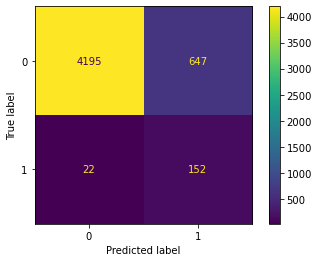

In [87]:
plot_confusion_matrix(best_under_pipeline, X_train_top_10, y_train);

In [88]:
precision_score_best_under = precision_score(y_train, best_under_pipeline.predict(X_train_top_10))
precision_scores['Undersampling'] = {'Train':precision_score_best_under, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0},
 'Oversampling': {'Train': 0.18969849246231155, 'Test': 0},
 'Undersampling': {'Train': 0.1902377972465582, 'Test': 0}}

In [89]:
recall_score_best_under = recall_score(y_train, best_under_pipeline.predict(X_train_top_10))
recall_scores['Undersampling'] = {'Train':recall_score_best_under, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0},
 'Oversampling': {'Train': 0.867816091954023, 'Test': 0},
 'Undersampling': {'Train': 0.8735632183908046, 'Test': 0}}

#### Analysis of Over and  Under Sampling
We can see that our over and under sampling methods yielded lower precision scores and higher recall scores than our class weight parameter and we'll proceed with using class weight.

### Fourth model with all predictors using our best parameters and under sampling

In [90]:
all_steps = [('ss', StandardScaler()),
              ('all', LogisticRegression(random_state=4, 
                                         class_weight={0: 0.870603015075377,
                                                       1: 0.12939698492462304}))]

In [91]:
all_pipeline = Pipeline(all_steps)

In [92]:
all_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('all',
                 LogisticRegression(class_weight={0: 0.870603015075377,
                                                  1: 0.12939698492462304},
                                    random_state=4))])

In [93]:
all_cv = cross_validate(all_pipeline, 
                        X_train, y_train, 
                        scoring=['precision', 'neg_log_loss'], 
                        cv=stratified_kfold, 
                        n_jobs=-1)

In [94]:
all_cv

{'fit_time': array([0.26230216, 0.24035883, 0.23138595, 0.22540021, 0.11266279]),
 'score_time': array([0.02393222, 0.02294064, 0.02493358, 0.02094436, 0.01795292]),
 'test_precision': array([0.33333333, 1.        , 0.55555556, 0.5       , 0.66666667]),
 'test_neg_log_loss': array([-0.14856857, -0.13745143, -0.14201381, -0.16624701, -0.13302841])}

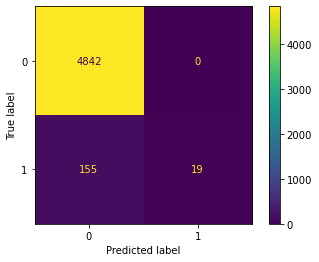

In [95]:
plot_confusion_matrix(all_pipeline, X_train, y_train);

In [96]:
precision_score_all = precision_score(y_train, all_pipeline.predict(X_train))
precision_scores['All Features'] = {'Train':precision_score_all, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0},
 'Oversampling': {'Train': 0.18969849246231155, 'Test': 0},
 'Undersampling': {'Train': 0.1902377972465582, 'Test': 0},
 'All Features': {'Train': 1.0, 'Test': 0}}

In [97]:
recall_score_all = recall_score(y_train, all_pipeline.predict(X_train))
recall_scores['All Features'] = {'Train':recall_score_all, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0},
 'Oversampling': {'Train': 0.867816091954023, 'Test': 0},
 'Undersampling': {'Train': 0.8735632183908046, 'Test': 0},
 'All Features': {'Train': 0.10919540229885058, 'Test': 0}}

In [98]:
print(classification_report(y_train, all_pipeline.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4842
           1       1.00      0.11      0.20       174

    accuracy                           0.97      5016
   macro avg       0.98      0.55      0.59      5016
weighted avg       0.97      0.97      0.96      5016



### Random Forests

We will continue running our model with a random forest classifier because it's a powerful ensemble method of classification.

In [99]:
weights = np.linspace(0.0,0.99,200)

In [100]:
rfc_balanced = RandomForestClassifier(bootstrap=False,
                                    criterion='entropy', 
                                    max_depth=10, 
                                    max_leaf_nodes=100,
                                    random_state=4)

In [101]:
rfc_balanced_param_grid = {'class_weight':[{0:x, 1:1.0-x} for x in weights]}

In [102]:
rfc_balanced_gsCV = GridSearchCV(estimator=rfc_balanced,
                                param_grid=rfc_balanced_param_grid,
                                scoring=['precision', 'neg_log_loss'],
                                cv=stratified_kfold,
                                n_jobs=-1,
                                refit='precision')

In [103]:
rfc_balanced_gsCV.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(bootstrap=False,
                                              criterion='entropy', max_depth=10,
                                              max_leaf_nodes=100,
                                              random_state=4),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.004974874371859297,
                                           1: 0.9950251256281407},
                                          {0: 0.009949748743718593,
                                           1: 0.9900502512562814},
                                          {0: 0.014924623115...
                                          {0: 0.11442211055276383,
                                           1: 0.8855778894472361},
                                          {0: 0.11939698492462311,
                                 

In [104]:
rfc_balanced_gsCV_1 = GridSearchCV(estimator=rfc_balanced,
                                param_grid=rfc_balanced_param_grid,
                                scoring=['precision', 'neg_log_loss'],
                                cv=stratified_kfold,
                                n_jobs=-1,
                                refit='neg_log_loss')

In [105]:
rfc_balanced_gsCV_1.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(bootstrap=False,
                                              criterion='entropy', max_depth=10,
                                              max_leaf_nodes=100,
                                              random_state=4),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.004974874371859297,
                                           1: 0.9950251256281407},
                                          {0: 0.009949748743718593,
                                           1: 0.9900502512562814},
                                          {0: 0.014924623115...
                                           1: 0.8855778894472361},
                                          {0: 0.11939698492462311,
                                           1: 0.8806030150753769},
                                 

In [106]:
rfc_balanced_gsCV.best_params_

{'class_weight': {0: 0.99, 1: 0.010000000000000009}}

In [107]:
rfc_balanced_gsCV_1.best_params_

{'class_weight': {0: 0.39798994974874374, 1: 0.6020100502512562}}

In [108]:
confusion_matrix(y_train, rfc_balanced_gsCV.best_estimator_.predict(X_train_top_10))

array([[4842,    0],
       [ 126,   48]], dtype=int64)

In [109]:
rfc_best_balance = RandomForestClassifier(bootstrap=False,
                        class_weight={0: 0.39798994974874374, 1: 0.6020100502512562},
                        criterion='entropy', max_depth=10, max_leaf_nodes=100,
                        random_state=4)

In [110]:
rfc_best_balance.fit(X_train_top_10, y_train)

RandomForestClassifier(bootstrap=False,
                       class_weight={0: 0.39798994974874374,
                                     1: 0.6020100502512562},
                       criterion='entropy', max_depth=10, max_leaf_nodes=100,
                       random_state=4)

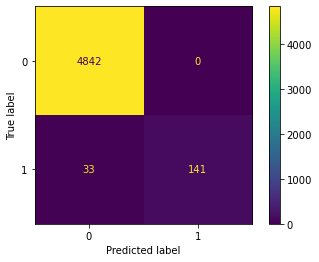

In [111]:
plot_confusion_matrix(rfc_best_balance, X_train_top_10, y_train);

In [112]:
recall_score_rfc_best_balance = recall_score(y_train, rfc_best_balance.predict(X_train_top_10))
recall_scores['Random Forest'] = {'Train':recall_score_rfc_best_balance, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0},
 'Oversampling': {'Train': 0.867816091954023, 'Test': 0},
 'Undersampling': {'Train': 0.8735632183908046, 'Test': 0},
 'All Features': {'Train': 0.10919540229885058, 'Test': 0},
 'Random Forest': {'Train': 0.8103448275862069, 'Test': 0}}

In [113]:
precision_score_rfc_best_balance = precision_score(y_train, rfc_best_balance.predict(X_train_top_10))
precision_scores['Random Forest'] = {'Train':precision_score_rfc_best_balance, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0},
 'Oversampling': {'Train': 0.18969849246231155, 'Test': 0},
 'Undersampling': {'Train': 0.1902377972465582, 'Test': 0},
 'All Features': {'Train': 1.0, 'Test': 0},
 'Random Forest': {'Train': 1.0, 'Test': 0}}

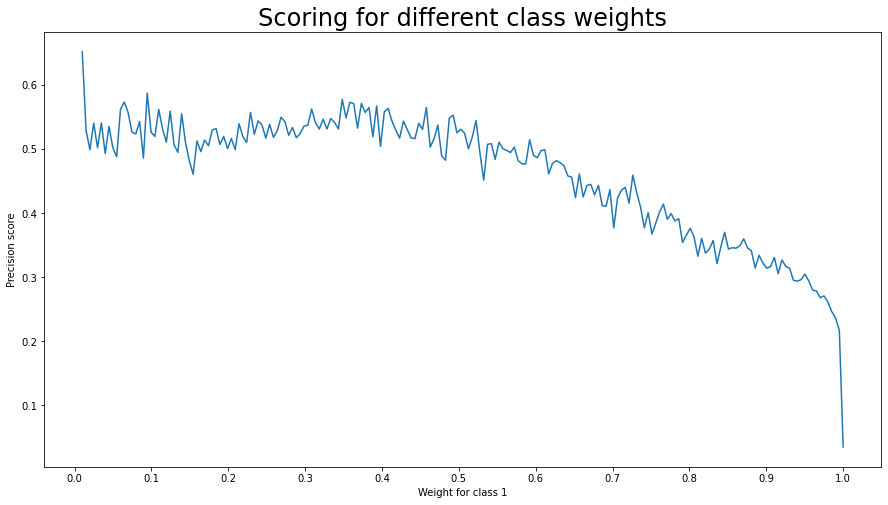

In [114]:
plt.figure(figsize=(15,8))
weigh_data = pd.DataFrame({ 'score': rfc_balanced_gsCV_1.cv_results_['mean_test_precision'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('Precision score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)
plt.savefig('./images/cw_scores.jpg', bbox_inches='tight')

### XGBoost Model

- After using random forest, we will use eXtreme Gradient Boosting, XGBoost, a method of gradient boosting which is building weak learning models on top of each other to achieve a better result. 

In [115]:
xgb_steps = [('sm', SMOTE(random_state=4)),
             ('xgb', xgboost.XGBClassifier(random_state=4))
            ]

In [116]:
xgb_imbpipe = imbpipeline(xgb_steps)
                        

In [117]:
xgb_params = {'xgb__eta' : [0.1,0.01,0.001],  # Learning rate
              'xgb__eval_metric': ['logloss'],
              'xgb__max_depth' : [3,6,9],
              'xgb__lambda' : [1,1.5,2],      # L2 regularization (higher values make model more conservative)
              'xgb__alpha' : [0,0.5,1]}


In [118]:
xgb_gsCV = GridSearchCV(xgb_imbpipe,
                       xgb_params,
                       scoring=['precision', 'neg_log_loss'],
                       cv=stratified_kfold,
                       refit='precision',
                       n_jobs=-1)

In [119]:
xgb_gsCV.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=4)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_st...
                                                    

In [120]:
xgb_gsCV.best_params_

{'xgb__alpha': 1,
 'xgb__eta': 0.1,
 'xgb__eval_metric': 'logloss',
 'xgb__lambda': 1,
 'xgb__max_depth': 9}

In [121]:
xgb_best_steps = [('sm', SMOTE(random_state=4)),
             ('xgb', xgboost.XGBClassifier(random_state=4,
                                           alpha=1,
                                           eta=0.1,
                                           eval_metric='logloss',
                                           reg_lambda=1,
                                           max_depth=9))]

In [122]:
xgb_best_pipe = imbpipeline(xgb_best_steps)

In [123]:
xgb_best_pipe.fit(X_train_top_10, y_train)

Pipeline(steps=[('sm', SMOTE(random_state=4)),
                ('xgb',
                 XGBClassifier(alpha=1, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.1,
                               eval_metric='logloss', gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step=0,
                               max_depth=9, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=4,
                               reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

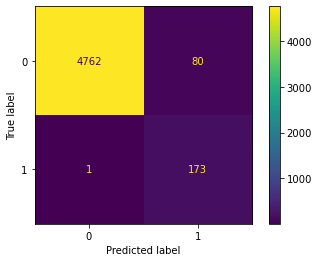

In [124]:
plot_confusion_matrix(xgb_best_pipe, X_train_top_10, y_train);

In [125]:
prob_pred_xgb = xgb_best_pipe.predict_proba(X_train_top_10)
prob_pred_xgb

array([[9.9956369e-01, 4.3630236e-04],
       [9.9313736e-01, 6.8626432e-03],
       [9.9242169e-01, 7.5782989e-03],
       ...,
       [9.9367255e-01, 6.3274531e-03],
       [7.6758897e-01, 2.3241104e-01],
       [9.9471301e-01, 5.2869632e-03]], dtype=float32)

In [126]:
prob_0 = prob_pred_xgb[:,0]

In [127]:
y_pred_xgb = np.where(prob_0 > 0.2, 0, 1)

In [128]:
xgb_cf = confusion_matrix(y_train, y_pred_xgb)

<AxesSubplot:>

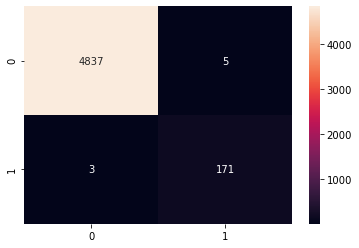

In [129]:
sns.heatmap(xgb_cf, annot=True, fmt='d')

In [130]:
precision_score_xgb_best_pipe = precision_score(y_train, (y_pred_xgb))
precision_scores['XGB Best'] = {'Train':precision_score_xgb_best_pipe, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0},
 'Oversampling': {'Train': 0.18969849246231155, 'Test': 0},
 'Undersampling': {'Train': 0.1902377972465582, 'Test': 0},
 'All Features': {'Train': 1.0, 'Test': 0},
 'Random Forest': {'Train': 1.0, 'Test': 0},
 'XGB Best': {'Train': 0.9715909090909091, 'Test': 0}}

In [131]:
recall_score_xgb_best_pipe = recall_score(y_train, (y_pred_xgb))
recall_scores['XGB Best'] = {'Train':recall_score_xgb_best_pipe, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0},
 'Oversampling': {'Train': 0.867816091954023, 'Test': 0},
 'Undersampling': {'Train': 0.8735632183908046, 'Test': 0},
 'All Features': {'Train': 0.10919540229885058, 'Test': 0},
 'Random Forest': {'Train': 0.8103448275862069, 'Test': 0},
 'XGB Best': {'Train': 0.9827586206896551, 'Test': 0}}

#### Feature importances from XGBoost model

In [132]:
xgmodel = xgboost.XGBClassifier(random_state=4,
                                           alpha=1,
                                           eta=0.1,
                                           eval_metric='logloss',
                                           reg_lambda=1,
                                           max_depth=9,)

In [133]:
xgmodel.fit(X_train_top_10, y_train)

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=4, reg_alpha=1, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [134]:
importance = pd.DataFrame(xgmodel.feature_importances_)

In [135]:
features = pd.DataFrame(top_cor_col)

In [136]:
features.rename(columns={0:'Features'}, inplace=True)

In [137]:
importance.rename(columns={0:'importance'}, inplace=True)

In [138]:
top_10_df = pd.concat([features, importance], axis=1)
df_10_sorted = top_10_df.sort_values(by='importance', ascending=False)

In [139]:
df_10_sorted

,Features,importance
6,Persistent EPS in the Last Four Seasons,0.30
0,Net Income to Total Assets,0.15
7,Retained Earnings to Total Assets,0.10
4,Net worth/Assets,0.10
8,Net profit before tax/Paid-in capital,0.09
1,ROA(A) before interest and % after tax,0.08
9,Per Share Net profit before tax (Yuan ¥),0.07
3,ROA(C) before interest and depreciation befor...,0.07
2,ROA(B) before interest and depreciation after...,0.05
5,Debt ratio %,0.00


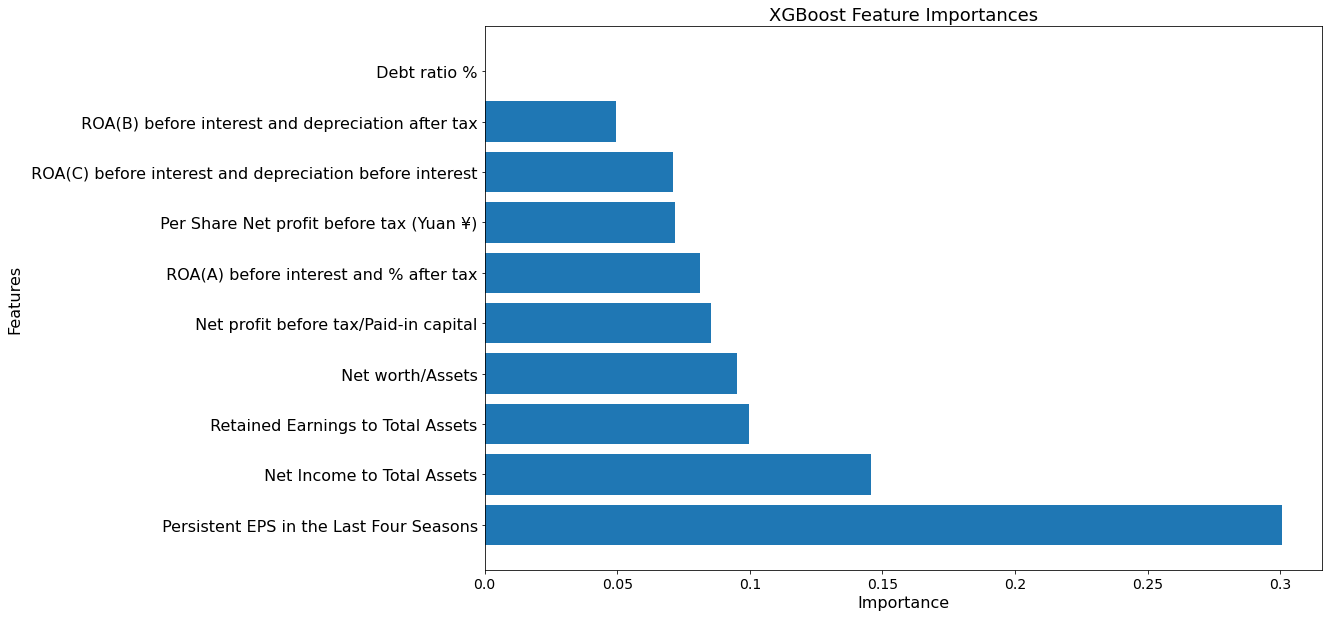

In [187]:
#plt.style.use("dark_background")
#sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(df_10_sorted['Features'], df_10_sorted['importance'])
ax.set_ylabel('Features', fontsize=16)
ax.set_xlabel('Importance', fontsize=16)
ax.set_title('XGBoost Feature Importances', fontsize=18)
ax.set_yticklabels(labels=df_10_sorted['Features'], fontsize=16)
ax.set_xticklabels(labels=[0.0, 0.05,0.10, 0.15, 0.20, 0.25, 0.30], fontsize=14)
plt.savefig('images/xgboost_top_features.jpg', bbox_inches='tight');

### CatBoost
- CatBoost is another boosting method we will implement.
- benefits of CatBoost:
    - "great quality without parameter tuning"
    - "categorical feature support"
    - "fast and scalable gpu version"
    - "improved accuracy"
    - "fast prediction"

In [141]:
from catboost import CatBoostClassifier

In [142]:
cat_steps = [('sm', SMOTE(random_state=4)),
             ('cb',CatBoostClassifier(random_state=4))
            ]

In [143]:
cat_pipe = imbpipeline(cat_steps)

In [144]:
cat_params = {'cb__eval_metric': ['Precision'],
              'cb__iterations': [100,500,1000],
              'cb__learning_rate' : [0.1,0.01,0.001],
              'cb__auto_class_weights' : ['Balanced','SqrtBalanced']
             }


In [145]:
cat_gsCV = GridSearchCV(cat_pipe,
                       cat_params,
                       scoring=['precision', 'neg_log_loss'],
                       cv=stratified_kfold,
                       refit='precision',
                       n_jobs=-1
                       )

In [146]:
cat_gsCV.fit(X_train_top_10, y_train)

0:	learn: 0.8471041	total: 160ms	remaining: 2m 40s
1:	learn: 0.8461538	total: 175ms	remaining: 1m 27s
2:	learn: 0.8486617	total: 186ms	remaining: 1m 1s
3:	learn: 0.8536191	total: 197ms	remaining: 49s
4:	learn: 0.8589253	total: 208ms	remaining: 41.3s
5:	learn: 0.8534348	total: 218ms	remaining: 36.2s
6:	learn: 0.8531469	total: 229ms	remaining: 32.5s
7:	learn: 0.8556441	total: 241ms	remaining: 29.8s
8:	learn: 0.8573396	total: 252ms	remaining: 27.7s
9:	learn: 0.8593963	total: 263ms	remaining: 26.1s
10:	learn: 0.8617458	total: 278ms	remaining: 25s
11:	learn: 0.8655660	total: 289ms	remaining: 23.8s
12:	learn: 0.8688363	total: 300ms	remaining: 22.8s
13:	learn: 0.8698899	total: 311ms	remaining: 21.9s
14:	learn: 0.8690359	total: 322ms	remaining: 21.1s
15:	learn: 0.8718603	total: 333ms	remaining: 20.5s
16:	learn: 0.8732809	total: 344ms	remaining: 19.9s
17:	learn: 0.8733058	total: 356ms	remaining: 19.4s
18:	learn: 0.8722778	total: 368ms	remaining: 19s
19:	learn: 0.8729163	total: 379ms	remaining: 

169:	learn: 0.9494326	total: 2.15s	remaining: 10.5s
170:	learn: 0.9496217	total: 2.17s	remaining: 10.5s
171:	learn: 0.9513168	total: 2.18s	remaining: 10.5s
172:	learn: 0.9509374	total: 2.2s	remaining: 10.5s
173:	learn: 0.9505582	total: 2.21s	remaining: 10.5s
174:	learn: 0.9509374	total: 2.23s	remaining: 10.5s
175:	learn: 0.9513266	total: 2.24s	remaining: 10.5s
176:	learn: 0.9517062	total: 2.25s	remaining: 10.5s
177:	learn: 0.9515260	total: 2.26s	remaining: 10.4s
178:	learn: 0.9521054	total: 2.27s	remaining: 10.4s
179:	learn: 0.9523049	total: 2.29s	remaining: 10.4s
180:	learn: 0.9530657	total: 2.3s	remaining: 10.4s
181:	learn: 0.9528848	total: 2.31s	remaining: 10.4s
182:	learn: 0.9528848	total: 2.32s	remaining: 10.3s
183:	learn: 0.9530751	total: 2.33s	remaining: 10.3s
184:	learn: 0.9534466	total: 2.34s	remaining: 10.3s
185:	learn: 0.9536556	total: 2.35s	remaining: 10.3s
186:	learn: 0.9536556	total: 2.36s	remaining: 10.3s
187:	learn: 0.9534651	total: 2.37s	remaining: 10.3s
188:	learn: 0.

335:	learn: 0.9804799	total: 4.12s	remaining: 8.14s
336:	learn: 0.9802805	total: 4.13s	remaining: 8.13s
337:	learn: 0.9804799	total: 4.14s	remaining: 8.12s
338:	learn: 0.9804838	total: 4.15s	remaining: 8.1s
339:	learn: 0.9804838	total: 4.17s	remaining: 8.09s
340:	learn: 0.9806832	total: 4.18s	remaining: 8.07s
341:	learn: 0.9806832	total: 4.19s	remaining: 8.06s
342:	learn: 0.9810822	total: 4.2s	remaining: 8.04s
343:	learn: 0.9812818	total: 4.21s	remaining: 8.03s
344:	learn: 0.9812818	total: 4.22s	remaining: 8.01s
345:	learn: 0.9812818	total: 4.23s	remaining: 8s
346:	learn: 0.9814815	total: 4.24s	remaining: 7.98s
347:	learn: 0.9818811	total: 4.25s	remaining: 7.97s
348:	learn: 0.9816813	total: 4.26s	remaining: 7.96s
349:	learn: 0.9816813	total: 4.28s	remaining: 7.94s
350:	learn: 0.9816813	total: 4.29s	remaining: 7.93s
351:	learn: 0.9816813	total: 4.3s	remaining: 7.92s
352:	learn: 0.9816813	total: 4.31s	remaining: 7.9s
353:	learn: 0.9822847	total: 4.32s	remaining: 7.89s
354:	learn: 0.98228

502:	learn: 0.9958831	total: 6.08s	remaining: 6s
503:	learn: 0.9960881	total: 6.09s	remaining: 5.99s
504:	learn: 0.9960881	total: 6.1s	remaining: 5.98s
505:	learn: 0.9960881	total: 6.11s	remaining: 5.96s
506:	learn: 0.9964985	total: 6.12s	remaining: 5.95s
507:	learn: 0.9969091	total: 6.13s	remaining: 5.94s
508:	learn: 0.9969098	total: 6.14s	remaining: 5.93s
509:	learn: 0.9967044	total: 6.15s	remaining: 5.91s
510:	learn: 0.9967044	total: 6.16s	remaining: 5.9s
511:	learn: 0.9969098	total: 6.18s	remaining: 5.89s
512:	learn: 0.9969104	total: 6.19s	remaining: 5.88s
513:	learn: 0.9971158	total: 6.2s	remaining: 5.86s
514:	learn: 0.9971158	total: 6.21s	remaining: 5.85s
515:	learn: 0.9973212	total: 6.22s	remaining: 5.84s
516:	learn: 0.9973212	total: 6.23s	remaining: 5.82s
517:	learn: 0.9971158	total: 6.24s	remaining: 5.81s
518:	learn: 0.9971158	total: 6.26s	remaining: 5.8s
519:	learn: 0.9971158	total: 6.27s	remaining: 5.79s
520:	learn: 0.9971158	total: 6.28s	remaining: 5.77s
521:	learn: 0.99711

663:	learn: 0.9993808	total: 7.86s	remaining: 3.98s
664:	learn: 0.9993808	total: 7.87s	remaining: 3.97s
665:	learn: 0.9993808	total: 7.88s	remaining: 3.95s
666:	learn: 0.9993808	total: 7.9s	remaining: 3.94s
667:	learn: 0.9993808	total: 7.91s	remaining: 3.93s
668:	learn: 0.9993808	total: 7.92s	remaining: 3.92s
669:	learn: 0.9993808	total: 7.93s	remaining: 3.9s
670:	learn: 0.9993808	total: 7.94s	remaining: 3.89s
671:	learn: 0.9993808	total: 7.95s	remaining: 3.88s
672:	learn: 0.9993808	total: 7.96s	remaining: 3.87s
673:	learn: 0.9993808	total: 7.97s	remaining: 3.85s
674:	learn: 0.9993808	total: 7.98s	remaining: 3.84s
675:	learn: 0.9993808	total: 7.99s	remaining: 3.83s
676:	learn: 0.9993808	total: 8s	remaining: 3.82s
677:	learn: 0.9993808	total: 8.01s	remaining: 3.81s
678:	learn: 0.9993808	total: 8.02s	remaining: 3.79s
679:	learn: 0.9993808	total: 8.04s	remaining: 3.78s
680:	learn: 0.9993808	total: 8.05s	remaining: 3.77s
681:	learn: 0.9993808	total: 8.06s	remaining: 3.76s
682:	learn: 0.999

824:	learn: 1.0000000	total: 9.65s	remaining: 2.05s
825:	learn: 1.0000000	total: 9.66s	remaining: 2.03s
826:	learn: 1.0000000	total: 9.67s	remaining: 2.02s
827:	learn: 1.0000000	total: 9.68s	remaining: 2.01s
828:	learn: 1.0000000	total: 9.69s	remaining: 2s
829:	learn: 1.0000000	total: 9.7s	remaining: 1.99s
830:	learn: 1.0000000	total: 9.71s	remaining: 1.98s
831:	learn: 1.0000000	total: 9.72s	remaining: 1.96s
832:	learn: 1.0000000	total: 9.74s	remaining: 1.95s
833:	learn: 1.0000000	total: 9.75s	remaining: 1.94s
834:	learn: 1.0000000	total: 9.76s	remaining: 1.93s
835:	learn: 1.0000000	total: 9.77s	remaining: 1.92s
836:	learn: 1.0000000	total: 9.78s	remaining: 1.9s
837:	learn: 1.0000000	total: 9.79s	remaining: 1.89s
838:	learn: 1.0000000	total: 9.8s	remaining: 1.88s
839:	learn: 1.0000000	total: 9.81s	remaining: 1.87s
840:	learn: 1.0000000	total: 9.82s	remaining: 1.86s
841:	learn: 1.0000000	total: 9.84s	remaining: 1.84s
842:	learn: 1.0000000	total: 9.85s	remaining: 1.83s
843:	learn: 1.0000

987:	learn: 1.0000000	total: 11.4s	remaining: 139ms
988:	learn: 1.0000000	total: 11.4s	remaining: 127ms
989:	learn: 1.0000000	total: 11.4s	remaining: 116ms
990:	learn: 1.0000000	total: 11.5s	remaining: 104ms
991:	learn: 1.0000000	total: 11.5s	remaining: 92.5ms
992:	learn: 1.0000000	total: 11.5s	remaining: 80.9ms
993:	learn: 1.0000000	total: 11.5s	remaining: 69.4ms
994:	learn: 1.0000000	total: 11.5s	remaining: 57.8ms
995:	learn: 1.0000000	total: 11.5s	remaining: 46.2ms
996:	learn: 1.0000000	total: 11.5s	remaining: 34.7ms
997:	learn: 1.0000000	total: 11.5s	remaining: 23.1ms
998:	learn: 1.0000000	total: 11.5s	remaining: 11.6ms
999:	learn: 1.0000000	total: 11.6s	remaining: 0us


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=4)),
                                       ('cb',
                                        <catboost.core.CatBoostClassifier object at 0x0000020E1B6EB700>)]),
             n_jobs=-1,
             param_grid={'cb__auto_class_weights': ['Balanced', 'SqrtBalanced'],
                         'cb__eval_metric': ['Precision'],
                         'cb__iterations': [100, 500, 1000],
                         'cb__learning_rate': [0.1, 0.01, 0.001]},
             refit='precision', scoring=['precision', 'neg_log_loss'])

In [147]:
cat_gsCV.best_params_

{'cb__auto_class_weights': 'Balanced',
 'cb__eval_metric': 'Precision',
 'cb__iterations': 1000,
 'cb__learning_rate': 0.1}

In [148]:
best_cat_steps = [('sm', SMOTE(random_state=4)),
             ('cb',CatBoostClassifier(random_state=4,
                                      auto_class_weights='Balanced',
                                      eval_metric='Precision',
                                      iterations=1000,
                                      learning_rate=0.1))]

In [149]:
best_cat_pipe = imbpipeline(best_cat_steps)

In [150]:
best_cat_pipe.fit(X_train_top_10, y_train)

0:	learn: 0.8471041	total: 11.8ms	remaining: 11.8s
1:	learn: 0.8461538	total: 23.2ms	remaining: 11.6s
2:	learn: 0.8486617	total: 35ms	remaining: 11.6s
3:	learn: 0.8536191	total: 46.7ms	remaining: 11.6s
4:	learn: 0.8589253	total: 57.3ms	remaining: 11.4s
5:	learn: 0.8534348	total: 68.3ms	remaining: 11.3s
6:	learn: 0.8531469	total: 79.5ms	remaining: 11.3s
7:	learn: 0.8556441	total: 91.2ms	remaining: 11.3s
8:	learn: 0.8573396	total: 103ms	remaining: 11.3s
9:	learn: 0.8593963	total: 114ms	remaining: 11.3s
10:	learn: 0.8617458	total: 125ms	remaining: 11.2s
11:	learn: 0.8655660	total: 136ms	remaining: 11.2s
12:	learn: 0.8688363	total: 158ms	remaining: 12s
13:	learn: 0.8698899	total: 170ms	remaining: 11.9s
14:	learn: 0.8690359	total: 180ms	remaining: 11.8s
15:	learn: 0.8718603	total: 191ms	remaining: 11.7s
16:	learn: 0.8732809	total: 203ms	remaining: 11.7s
17:	learn: 0.8733058	total: 216ms	remaining: 11.8s
18:	learn: 0.8722778	total: 230ms	remaining: 11.9s
19:	learn: 0.8729163	total: 242ms	rem

168:	learn: 0.9497608	total: 2s	remaining: 9.84s
169:	learn: 0.9494326	total: 2.01s	remaining: 9.82s
170:	learn: 0.9496217	total: 2.02s	remaining: 9.8s
171:	learn: 0.9513168	total: 2.03s	remaining: 9.79s
172:	learn: 0.9509374	total: 2.04s	remaining: 9.78s
173:	learn: 0.9505582	total: 2.06s	remaining: 9.76s
174:	learn: 0.9509374	total: 2.07s	remaining: 9.75s
175:	learn: 0.9513266	total: 2.08s	remaining: 9.74s
176:	learn: 0.9517062	total: 2.09s	remaining: 9.72s
177:	learn: 0.9515260	total: 2.1s	remaining: 9.71s
178:	learn: 0.9521054	total: 2.11s	remaining: 9.69s
179:	learn: 0.9523049	total: 2.12s	remaining: 9.68s
180:	learn: 0.9530657	total: 2.13s	remaining: 9.66s
181:	learn: 0.9528848	total: 2.15s	remaining: 9.64s
182:	learn: 0.9528848	total: 2.16s	remaining: 9.63s
183:	learn: 0.9530751	total: 2.17s	remaining: 9.61s
184:	learn: 0.9534466	total: 2.18s	remaining: 9.61s
185:	learn: 0.9536556	total: 2.19s	remaining: 9.6s
186:	learn: 0.9536556	total: 2.2s	remaining: 9.58s
187:	learn: 0.95346

327:	learn: 0.9798699	total: 3.78s	remaining: 7.75s
328:	learn: 0.9796748	total: 3.79s	remaining: 7.73s
329:	learn: 0.9798740	total: 3.81s	remaining: 7.73s
330:	learn: 0.9800732	total: 3.82s	remaining: 7.72s
331:	learn: 0.9800732	total: 3.83s	remaining: 7.71s
332:	learn: 0.9800732	total: 3.84s	remaining: 7.7s
333:	learn: 0.9800732	total: 3.86s	remaining: 7.69s
334:	learn: 0.9800732	total: 3.87s	remaining: 7.68s
335:	learn: 0.9804799	total: 3.88s	remaining: 7.66s
336:	learn: 0.9802805	total: 3.89s	remaining: 7.65s
337:	learn: 0.9804799	total: 3.9s	remaining: 7.64s
338:	learn: 0.9804838	total: 3.91s	remaining: 7.63s
339:	learn: 0.9804838	total: 3.92s	remaining: 7.61s
340:	learn: 0.9806832	total: 3.93s	remaining: 7.6s
341:	learn: 0.9806832	total: 3.94s	remaining: 7.59s
342:	learn: 0.9810822	total: 3.96s	remaining: 7.58s
343:	learn: 0.9812818	total: 3.97s	remaining: 7.56s
344:	learn: 0.9812818	total: 3.98s	remaining: 7.55s
345:	learn: 0.9812818	total: 3.99s	remaining: 7.54s
346:	learn: 0.9

500:	learn: 0.9958831	total: 5.75s	remaining: 5.73s
501:	learn: 0.9958831	total: 5.76s	remaining: 5.72s
502:	learn: 0.9958831	total: 5.77s	remaining: 5.71s
503:	learn: 0.9960881	total: 5.79s	remaining: 5.69s
504:	learn: 0.9960881	total: 5.8s	remaining: 5.68s
505:	learn: 0.9960881	total: 5.81s	remaining: 5.67s
506:	learn: 0.9964985	total: 5.82s	remaining: 5.66s
507:	learn: 0.9969091	total: 5.83s	remaining: 5.64s
508:	learn: 0.9969098	total: 5.84s	remaining: 5.63s
509:	learn: 0.9967044	total: 5.85s	remaining: 5.62s
510:	learn: 0.9967044	total: 5.86s	remaining: 5.61s
511:	learn: 0.9969098	total: 5.87s	remaining: 5.6s
512:	learn: 0.9969104	total: 5.88s	remaining: 5.59s
513:	learn: 0.9971158	total: 5.9s	remaining: 5.58s
514:	learn: 0.9971158	total: 5.91s	remaining: 5.56s
515:	learn: 0.9973212	total: 5.92s	remaining: 5.55s
516:	learn: 0.9973212	total: 5.93s	remaining: 5.54s
517:	learn: 0.9971158	total: 5.95s	remaining: 5.53s
518:	learn: 0.9971158	total: 5.96s	remaining: 5.52s
519:	learn: 0.9

661:	learn: 0.9993808	total: 7.56s	remaining: 3.86s
662:	learn: 0.9993808	total: 7.57s	remaining: 3.85s
663:	learn: 0.9993808	total: 7.59s	remaining: 3.84s
664:	learn: 0.9993808	total: 7.6s	remaining: 3.83s
665:	learn: 0.9993808	total: 7.61s	remaining: 3.81s
666:	learn: 0.9993808	total: 7.62s	remaining: 3.8s
667:	learn: 0.9993808	total: 7.63s	remaining: 3.79s
668:	learn: 0.9993808	total: 7.64s	remaining: 3.78s
669:	learn: 0.9993808	total: 7.65s	remaining: 3.77s
670:	learn: 0.9993808	total: 7.66s	remaining: 3.76s
671:	learn: 0.9993808	total: 7.67s	remaining: 3.75s
672:	learn: 0.9993808	total: 7.68s	remaining: 3.73s
673:	learn: 0.9993808	total: 7.7s	remaining: 3.72s
674:	learn: 0.9993808	total: 7.71s	remaining: 3.71s
675:	learn: 0.9993808	total: 7.72s	remaining: 3.7s
676:	learn: 0.9993808	total: 7.73s	remaining: 3.69s
677:	learn: 0.9993808	total: 7.74s	remaining: 3.67s
678:	learn: 0.9993808	total: 7.75s	remaining: 3.66s
679:	learn: 0.9993808	total: 7.76s	remaining: 3.65s
680:	learn: 0.99

822:	learn: 1.0000000	total: 9.35s	remaining: 2.01s
823:	learn: 1.0000000	total: 9.36s	remaining: 2s
824:	learn: 1.0000000	total: 9.37s	remaining: 1.99s
825:	learn: 1.0000000	total: 9.38s	remaining: 1.98s
826:	learn: 1.0000000	total: 9.39s	remaining: 1.96s
827:	learn: 1.0000000	total: 9.4s	remaining: 1.95s
828:	learn: 1.0000000	total: 9.41s	remaining: 1.94s
829:	learn: 1.0000000	total: 9.42s	remaining: 1.93s
830:	learn: 1.0000000	total: 9.44s	remaining: 1.92s
831:	learn: 1.0000000	total: 9.45s	remaining: 1.91s
832:	learn: 1.0000000	total: 9.46s	remaining: 1.9s
833:	learn: 1.0000000	total: 9.47s	remaining: 1.88s
834:	learn: 1.0000000	total: 9.48s	remaining: 1.87s
835:	learn: 1.0000000	total: 9.49s	remaining: 1.86s
836:	learn: 1.0000000	total: 9.5s	remaining: 1.85s
837:	learn: 1.0000000	total: 9.51s	remaining: 1.84s
838:	learn: 1.0000000	total: 9.52s	remaining: 1.83s
839:	learn: 1.0000000	total: 9.54s	remaining: 1.82s
840:	learn: 1.0000000	total: 9.55s	remaining: 1.8s
841:	learn: 1.00000

993:	learn: 1.0000000	total: 11.3s	remaining: 68.3ms
994:	learn: 1.0000000	total: 11.3s	remaining: 56.9ms
995:	learn: 1.0000000	total: 11.3s	remaining: 45.5ms
996:	learn: 1.0000000	total: 11.4s	remaining: 34.2ms
997:	learn: 1.0000000	total: 11.4s	remaining: 22.8ms
998:	learn: 1.0000000	total: 11.4s	remaining: 11.4ms
999:	learn: 1.0000000	total: 11.4s	remaining: 0us


Pipeline(steps=[('sm', SMOTE(random_state=4)),
                ('cb',
                 <catboost.core.CatBoostClassifier object at 0x0000020E1B6EB040>)])

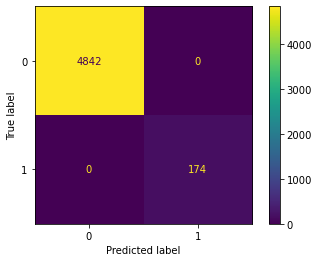

In [151]:
plot_confusion_matrix(best_cat_pipe, X_train_top_10, y_train);

In [152]:
precision_score_best_cat_pipe = precision_score(y_train, best_cat_pipe.predict(X_train_top_10))
precision_scores['CatBoost'] = {'Train':precision_score_best_cat_pipe, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0},
 'Oversampling': {'Train': 0.18969849246231155, 'Test': 0},
 'Undersampling': {'Train': 0.1902377972465582, 'Test': 0},
 'All Features': {'Train': 1.0, 'Test': 0},
 'Random Forest': {'Train': 1.0, 'Test': 0},
 'XGB Best': {'Train': 0.9715909090909091, 'Test': 0},
 'CatBoost': {'Train': 1.0, 'Test': 0}}

In [153]:
recall_score_best_cat_pipe = recall_score(y_train, best_cat_pipe.predict(X_train_top_10))
recall_scores['CatBoost'] = {'Train':recall_score_best_cat_pipe, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0},
 'Oversampling': {'Train': 0.867816091954023, 'Test': 0},
 'Undersampling': {'Train': 0.8735632183908046, 'Test': 0},
 'All Features': {'Train': 0.10919540229885058, 'Test': 0},
 'Random Forest': {'Train': 0.8103448275862069, 'Test': 0},
 'XGB Best': {'Train': 0.9827586206896551, 'Test': 0},
 'CatBoost': {'Train': 1.0, 'Test': 0}}

#### Feature Importances from CatBoost

In [154]:
boosted_cat = CatBoostClassifier(random_state=4,
                                      auto_class_weights='Balanced',
                                      eval_metric='Precision',
                                      iterations=1000,
                                      learning_rate=0.1)

In [155]:
boosted_cat.fit(X_train_top_10, y_train)

0:	learn: 0.8004738	total: 8.59ms	remaining: 8.58s
1:	learn: 0.8235604	total: 18.8ms	remaining: 9.39s
2:	learn: 0.8381959	total: 27.8ms	remaining: 9.25s
3:	learn: 0.8407934	total: 37.3ms	remaining: 9.28s
4:	learn: 0.8404217	total: 45.1ms	remaining: 8.97s
5:	learn: 0.8438989	total: 53.7ms	remaining: 8.9s
6:	learn: 0.8478525	total: 62.4ms	remaining: 8.85s
7:	learn: 0.8471959	total: 70.3ms	remaining: 8.71s
8:	learn: 0.8463753	total: 77.8ms	remaining: 8.57s
9:	learn: 0.8451813	total: 86.9ms	remaining: 8.6s
10:	learn: 0.8488721	total: 94.6ms	remaining: 8.51s
11:	learn: 0.8500431	total: 103ms	remaining: 8.44s
12:	learn: 0.8512482	total: 110ms	remaining: 8.37s
13:	learn: 0.8530193	total: 118ms	remaining: 8.33s
14:	learn: 0.8603762	total: 127ms	remaining: 8.31s
15:	learn: 0.8634710	total: 134ms	remaining: 8.26s
16:	learn: 0.8639737	total: 142ms	remaining: 8.21s
17:	learn: 0.8633036	total: 152ms	remaining: 8.27s
18:	learn: 0.8610513	total: 159ms	remaining: 8.23s
19:	learn: 0.8614662	total: 167m

167:	learn: 0.9693694	total: 1.41s	remaining: 6.98s
168:	learn: 0.9697577	total: 1.42s	remaining: 6.97s
169:	learn: 0.9705352	total: 1.43s	remaining: 6.96s
170:	learn: 0.9713139	total: 1.43s	remaining: 6.95s
171:	learn: 0.9713139	total: 1.44s	remaining: 6.94s
172:	learn: 0.9715088	total: 1.45s	remaining: 6.93s
173:	learn: 0.9717038	total: 1.46s	remaining: 6.92s
174:	learn: 0.9720940	total: 1.47s	remaining: 6.91s
175:	learn: 0.9724844	total: 1.47s	remaining: 6.9s
176:	learn: 0.9722892	total: 1.48s	remaining: 6.89s
177:	learn: 0.9724844	total: 1.49s	remaining: 6.88s
178:	learn: 0.9728752	total: 1.5s	remaining: 6.87s
179:	learn: 0.9734620	total: 1.51s	remaining: 6.86s
180:	learn: 0.9738536	total: 1.51s	remaining: 6.85s
181:	learn: 0.9740495	total: 1.52s	remaining: 6.84s
182:	learn: 0.9746377	total: 1.53s	remaining: 6.83s
183:	learn: 0.9746377	total: 1.54s	remaining: 6.82s
184:	learn: 0.9750302	total: 1.54s	remaining: 6.81s
185:	learn: 0.9756196	total: 1.55s	remaining: 6.8s
186:	learn: 0.9

341:	learn: 0.9967065	total: 2.82s	remaining: 5.42s
342:	learn: 0.9965013	total: 2.83s	remaining: 5.42s
343:	learn: 0.9969117	total: 2.84s	remaining: 5.41s
344:	learn: 0.9967065	total: 2.84s	remaining: 5.4s
345:	learn: 0.9969117	total: 2.85s	remaining: 5.39s
346:	learn: 0.9969117	total: 2.86s	remaining: 5.38s
347:	learn: 0.9969117	total: 2.87s	remaining: 5.37s
348:	learn: 0.9969117	total: 2.88s	remaining: 5.36s
349:	learn: 0.9969117	total: 2.88s	remaining: 5.35s
350:	learn: 0.9971170	total: 2.89s	remaining: 5.35s
351:	learn: 0.9971170	total: 2.9s	remaining: 5.34s
352:	learn: 0.9971170	total: 2.91s	remaining: 5.33s
353:	learn: 0.9973223	total: 2.92s	remaining: 5.32s
354:	learn: 0.9973223	total: 2.92s	remaining: 5.31s
355:	learn: 0.9973223	total: 2.93s	remaining: 5.3s
356:	learn: 0.9973223	total: 2.94s	remaining: 5.29s
357:	learn: 0.9973223	total: 2.95s	remaining: 5.28s
358:	learn: 0.9975278	total: 2.95s	remaining: 5.27s
359:	learn: 0.9975278	total: 2.96s	remaining: 5.27s
360:	learn: 0.9

515:	learn: 0.9995871	total: 4.23s	remaining: 3.96s
516:	learn: 0.9995871	total: 4.23s	remaining: 3.96s
517:	learn: 0.9995871	total: 4.24s	remaining: 3.95s
518:	learn: 0.9997935	total: 4.25s	remaining: 3.94s
519:	learn: 0.9997935	total: 4.26s	remaining: 3.93s
520:	learn: 0.9997935	total: 4.27s	remaining: 3.92s
521:	learn: 0.9997935	total: 4.27s	remaining: 3.91s
522:	learn: 0.9997935	total: 4.28s	remaining: 3.9s
523:	learn: 0.9997935	total: 4.29s	remaining: 3.9s
524:	learn: 0.9997935	total: 4.3s	remaining: 3.89s
525:	learn: 0.9997935	total: 4.3s	remaining: 3.88s
526:	learn: 0.9997935	total: 4.31s	remaining: 3.87s
527:	learn: 0.9997935	total: 4.32s	remaining: 3.86s
528:	learn: 0.9997935	total: 4.33s	remaining: 3.85s
529:	learn: 0.9997935	total: 4.34s	remaining: 3.85s
530:	learn: 0.9997935	total: 4.34s	remaining: 3.84s
531:	learn: 0.9997935	total: 4.35s	remaining: 3.83s
532:	learn: 0.9997935	total: 4.36s	remaining: 3.82s
533:	learn: 0.9997935	total: 4.37s	remaining: 3.81s
534:	learn: 0.99

692:	learn: 1.0000000	total: 5.63s	remaining: 2.49s
693:	learn: 1.0000000	total: 5.64s	remaining: 2.48s
694:	learn: 1.0000000	total: 5.64s	remaining: 2.48s
695:	learn: 1.0000000	total: 5.65s	remaining: 2.47s
696:	learn: 1.0000000	total: 5.66s	remaining: 2.46s
697:	learn: 1.0000000	total: 5.67s	remaining: 2.45s
698:	learn: 1.0000000	total: 5.67s	remaining: 2.44s
699:	learn: 1.0000000	total: 5.68s	remaining: 2.43s
700:	learn: 1.0000000	total: 5.69s	remaining: 2.43s
701:	learn: 1.0000000	total: 5.7s	remaining: 2.42s
702:	learn: 1.0000000	total: 5.7s	remaining: 2.41s
703:	learn: 1.0000000	total: 5.71s	remaining: 2.4s
704:	learn: 1.0000000	total: 5.72s	remaining: 2.39s
705:	learn: 1.0000000	total: 5.72s	remaining: 2.38s
706:	learn: 1.0000000	total: 5.73s	remaining: 2.38s
707:	learn: 1.0000000	total: 5.74s	remaining: 2.37s
708:	learn: 1.0000000	total: 5.75s	remaining: 2.36s
709:	learn: 1.0000000	total: 5.75s	remaining: 2.35s
710:	learn: 1.0000000	total: 5.76s	remaining: 2.34s
711:	learn: 1.0

858:	learn: 1.0000000	total: 6.85s	remaining: 1.12s
859:	learn: 1.0000000	total: 6.86s	remaining: 1.12s
860:	learn: 1.0000000	total: 6.87s	remaining: 1.11s
861:	learn: 1.0000000	total: 6.87s	remaining: 1.1s
862:	learn: 1.0000000	total: 6.88s	remaining: 1.09s
863:	learn: 1.0000000	total: 6.89s	remaining: 1.08s
864:	learn: 1.0000000	total: 6.89s	remaining: 1.07s
865:	learn: 1.0000000	total: 6.9s	remaining: 1.07s
866:	learn: 1.0000000	total: 6.91s	remaining: 1.06s
867:	learn: 1.0000000	total: 6.91s	remaining: 1.05s
868:	learn: 1.0000000	total: 6.92s	remaining: 1.04s
869:	learn: 1.0000000	total: 6.93s	remaining: 1.03s
870:	learn: 1.0000000	total: 6.93s	remaining: 1.03s
871:	learn: 1.0000000	total: 6.94s	remaining: 1.02s
872:	learn: 1.0000000	total: 6.95s	remaining: 1.01s
873:	learn: 1.0000000	total: 6.96s	remaining: 1s
874:	learn: 1.0000000	total: 6.96s	remaining: 995ms
875:	learn: 1.0000000	total: 6.97s	remaining: 987ms
876:	learn: 1.0000000	total: 6.98s	remaining: 979ms
877:	learn: 1.000

In [156]:
important_cat = boosted_cat.get_feature_importance()

In [157]:
important_cat = pd.DataFrame(important_cat)

In [158]:
top_cat_features = pd.concat([features, important_cat], axis=1)

In [159]:
top_cat_features.rename(columns={0:'Importance'}, inplace=True)

In [160]:
sorted_top_cat = top_cat_features.sort_values(by='Importance', ascending=False)
sorted_top_cat

,Features,Importance
4,Net worth/Assets,13.81
7,Retained Earnings to Total Assets,13.15
5,Debt ratio %,10.98
1,ROA(A) before interest and % after tax,10.47
0,Net Income to Total Assets,10.04
8,Net profit before tax/Paid-in capital,9.49
2,ROA(B) before interest and depreciation after...,9.23
6,Persistent EPS in the Last Four Seasons,8.82
3,ROA(C) before interest and depreciation befor...,7.19
9,Per Share Net profit before tax (Yuan ¥),6.83


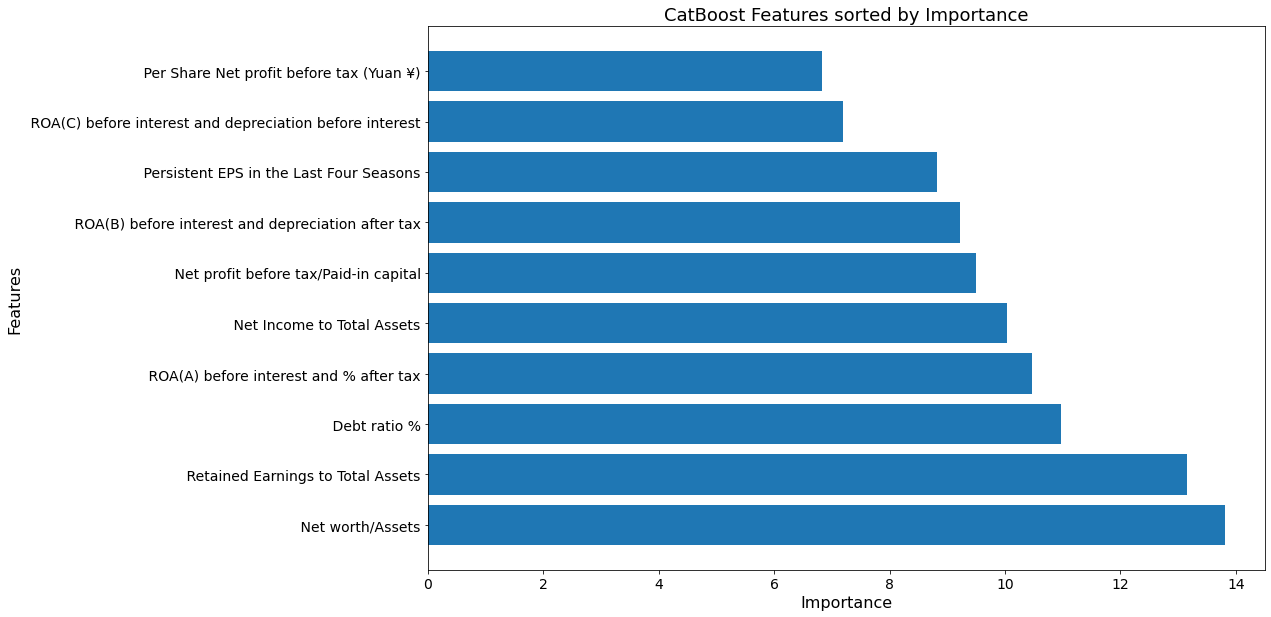

In [188]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(sorted_top_cat['Features'], sorted_top_cat['Importance'])
ax.set_ylabel('Features', fontsize=16)
ax.set_xlabel('Importance', fontsize=16)
ax.set_title('CatBoost Features sorted by Importance', fontsize=18)
ax.set_yticklabels(labels=sorted_top_cat['Features'], fontsize=14)
ax.set_xticklabels(labels=np.arange(0,16,2), fontsize=14);

## Validation

- Below we will calculate our precision and recall scores from our models using our testing data.

In [162]:
precision_df = pd.DataFrame(precision_scores)
recall_df = pd.DataFrame(recall_scores)

In [163]:
precision_1_df = precision_df.copy()
recall_1_df = recall_df.copy()

In [164]:
precision_1_df['Baseline']['Test'] = precision_score(y_test, debt_pipeline.predict(X_test_debt))
recall_1_df['Baseline']['Test'] = recall_score(y_test, debt_pipeline.predict(X_test_debt))

In [165]:
precision_1_df['Top 10']['Test'] = precision_score(y_test, top_10_pipeline.predict(X_test_top_10))
recall_1_df['Top 10']['Test'] = recall_score(y_test, top_10_pipeline.predict(X_test_top_10))

In [166]:
precision_1_df['Random Forest']['Test'] = precision_score(y_test, rfc_best_balance.predict(X_test_top_10))
recall_1_df['Random Forest']['Test'] = recall_score(y_test, rfc_best_balance.predict(X_test_top_10))

In [167]:
test_prob_pred_xgb = xgb_best_pipe.predict_proba(X_test_top_10)
test_prob_pred_xgb

array([[9.9967867e-01, 3.2133912e-04],
       [9.9684757e-01, 3.1524205e-03],
       [9.9864757e-01, 1.3524230e-03],
       ...,
       [9.9962556e-01, 3.7440902e-04],
       [9.5677567e-01, 4.3224324e-02],
       [5.7007074e-03, 9.9429929e-01]], dtype=float32)

In [168]:
test_prob_0 = test_prob_pred_xgb[:,0]

In [169]:
y_test_pred_xgb = np.where(test_prob_0 > .2, 0, 1)

In [170]:
test_xgb_cf = confusion_matrix(y_test, y_test_pred_xgb)
test_xgb_cf

array([[1175,   35],
       [  22,   22]], dtype=int64)

In [171]:
precision_1_df['XGB Best']['Test'] = precision_score(y_test, y_test_pred_xgb)
recall_1_df['XGB Best']['Test'] = recall_score(y_test, y_test_pred_xgb)

In [172]:
precision_1_df['CatBoost']['Test'] = precision_score(y_test, best_cat_pipe.predict(X_test_top_10))
recall_1_df['CatBoost']['Test'] = recall_score(y_test, best_cat_pipe.predict(X_test_top_10))

## Plotting our scores
- Below we will plot our training and test precision and recall scores for our Baseline, Top 10 Features, Random Forest, XGBoost, and Catboost models.

In [173]:
precision_1_df.drop(['Class Weight', 'Oversampling', 'Undersampling', 'All Features'], axis=1, inplace=True)

In [174]:
precision_1_df

,Baseline,Top 10,Random Forest,XGB Best,CatBoost
Train,0.69,0.52,1.00,0.97,1.00
Test,1.00,0.50,0.52,0.39,0.28


In [175]:
recall_1_df = recall_1_df.drop(['Class Weight', 'Oversampling', 'Undersampling', 'All Features'], axis=1)


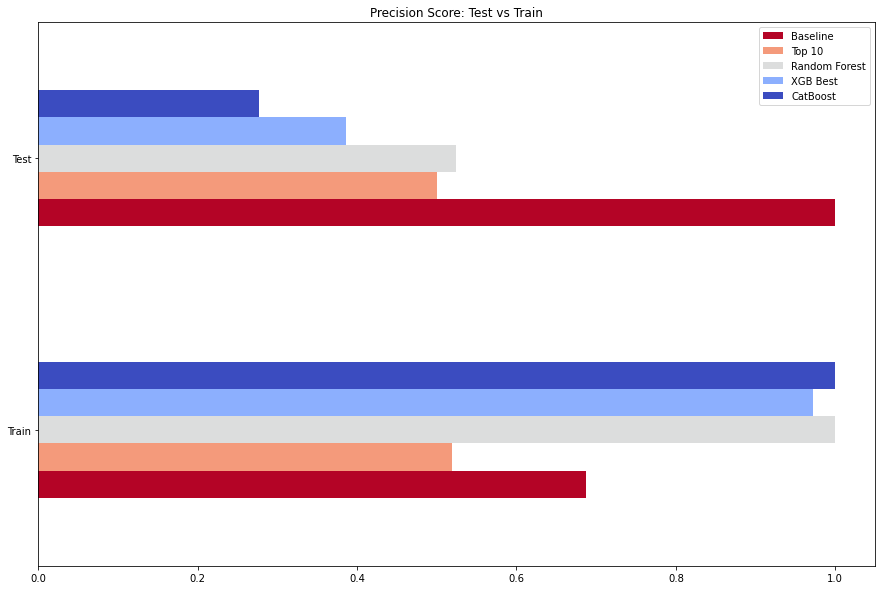

In [185]:
precision_1_df.plot(kind='barh', figsize=(15,10),colormap='coolwarm_r', title='Precision Score: Test vs Train')
ax.set_title('Precision Test vs Train')
plt.savefig('./images/precision_score_bar_normal.jpg', bbox_inches='tight');

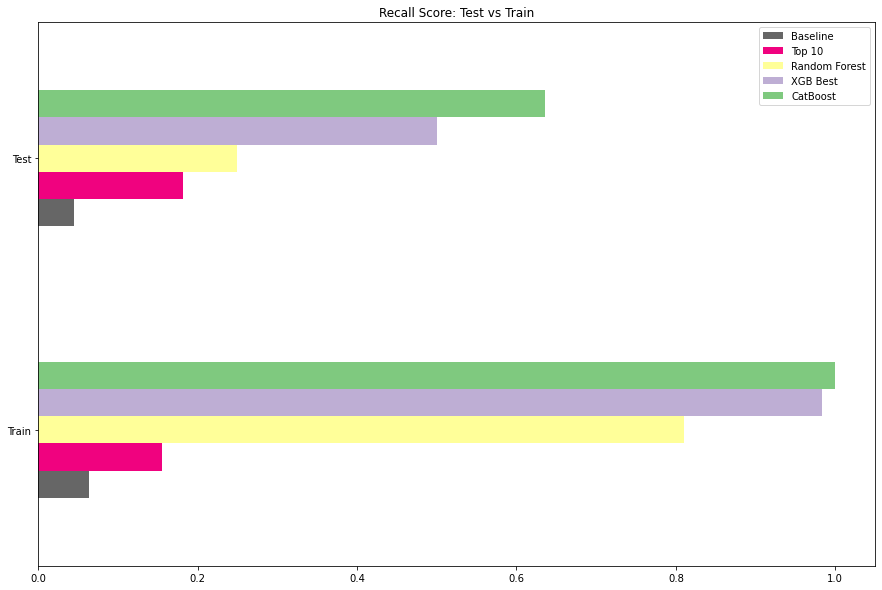

In [177]:
recall_1_df.plot(kind='barh', figsize=(15, 10), colormap='Accent_r', title='Recall Score: Test vs Train')
plt.savefig('./images/recall_score_bar.jpg', bbox_inches='tight');

#### Test Confusion Matrices

- Baseline Test Confusion Matrix

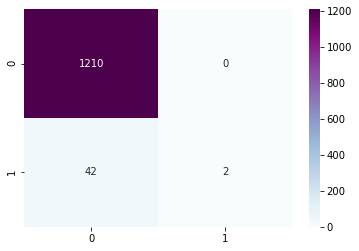

In [178]:
Baseline_cf = confusion_matrix(y_test, debt_pipeline.predict(X_test_debt))
sns.heatmap(Baseline_cf, annot=True, fmt='d', cmap="BuPu");

- Top 10 Test Confusion Matrix

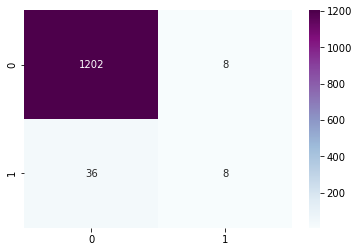

In [179]:
top_10_cf = confusion_matrix(y_test, top_10_pipeline.predict(X_test_top_10))
sns.heatmap(top_10_cf, annot=True, fmt='d', cmap="BuPu");

- Random Forest Classifier Test Confusion Matrix

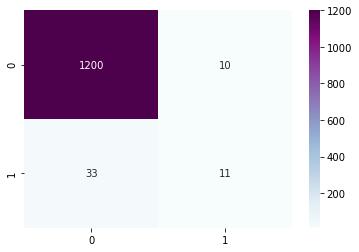

In [180]:
rfc_cf = confusion_matrix(y_test, rfc_best_balance.predict(X_test_top_10))
sns.heatmap(rfc_cf, annot=True, fmt='d', cmap="BuPu");

- XGBoost with Threshold .8/ .2 Test Confusion Matrix

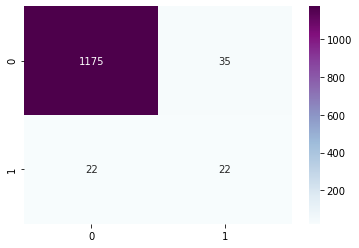

In [181]:
sns.heatmap(test_xgb_cf, annot=True, fmt='d', cmap="BuPu")
plt.savefig('./images/xgb_conf_matrix.jpg');

- XGBoost confusion matrix without threshold

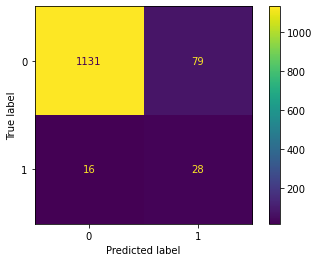

In [182]:
plot_confusion_matrix(xgb_best_pipe, X_test_top_10, y_test);

- CatBoost Test Confusion Matrix

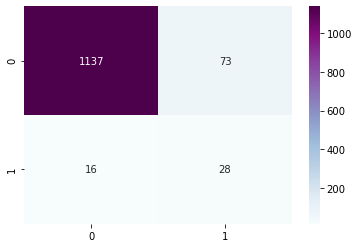

In [183]:
CatBoost_cf = confusion_matrix(y_test, best_cat_pipe.predict(X_test_top_10))
sns.heatmap(CatBoost_cf, annot=True, fmt='d', cmap="BuPu");

Above, we can observe our Random Forest, CatBoost, and XGBoost models with a high training precision scores perform worse on the testing data, suggesting our models were overfit on the training data. Our recall scores for those three also dropped when we applied test data to the models.

## Final Analysis and Conclusion
We tuned our models towards precision to minimize Type I errors, also known as false positives. The model with the highest training precision score was our XGBoost model. When we ran this model on our testing set, it did not perform as well as on the training set. This might be because we did not include the threshold into cross validation. 


### Next Steps
Further analysis we could pursue to better predict bankruptcy in Taiwan: 
- We can manually run Stratified K Folding with threshold implementation to fix the threshold issue
- Add data and information such as dates of bankruptcy
- Continue to think of new parameters and different modelling strategies 